In [33]:
import pandas as pd
import psycopg2
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import alpaca_trade_api as tradeapi
import numpy as np
import requests
from scipy import stats
from talib import MACD, RSI, BBANDS
from datetime import datetime, timedelta, date
from IPython.display import display, HTML
%matplotlib inline
import json
import math
from dateutil import parser

In [34]:
start_day_to_analyze = '2020-03-04'
end_day_to_analyze = '2020-03-05'

In [35]:
base_url = "https://api.alpaca.markets"
api_key_id = "PKO3OSD9LU9GTQPL69GO"
api_secret = "chnPFlGXbY4Y4QAAZ3Q7MJHxkxBYB30CQZNVZTaj"

In [36]:
db_conn = create_engine("postgresql://momentum@localhost:5432/tradedb")

In [37]:
api = tradeapi.REST(
    base_url=base_url, key_id=api_key_id, secret_key=api_secret
)
session = requests.session()

In [38]:
query = f'''
SELECT * 
FROM 
trades as t
WHERE 
    buy_time >= '{start_day_to_analyze}' and 
    buy_time < '{end_day_to_analyze}' 
ORDER BY symbol, buy_time
'''
trades =  pd.read_sql_query(query, db_conn)

In [39]:
query = f'''
SELECT * 
FROM 
algo_run as t
WHERE 
    start_time >= '{start_day_to_analyze}' and 
    start_time < '{end_day_to_analyze}' 
'''
algo_runs = pd.read_sql_query(query, db_conn)

In [40]:
trade_details = {}

for index, row in trades.iterrows():
    algo_run_id = row['algo_run_id']
    symbol = row['symbol']
    buy_time = row['client_buy_time']
    buy_price = row['buy_price']
    sell_time = row['client_sell_time']
    sell_price = row['sell_price']
    buy_indicator = row['buy_indicators']
    sell_indicator = row['sell_indicators']
    qty = row['qty'] 
    if algo_run_id not in trade_details:
        trade_details[algo_run_id] = {}
    if symbol not in trade_details[algo_run_id]:
        trade_details[algo_run_id][symbol] = []
    trade_details[algo_run_id][symbol].append((buy_time, buy_price, sell_time, sell_price, buy_indicator, sell_indicator, qty))

In [41]:
runs = trades['algo_run_id'].value_counts()
revenues = {}
how_was_my_day = {}
for run_id, count in runs.items():
    symbols = trades.loc[trades['algo_run_id'] == run_id]['symbol'].value_counts()
    revenues[run_id] = []
    precentages = []
    symbol_name = []
    counts = []
    for symbol, count in symbols.items():
        revnue = 0
        precentage = 0.0

        for trade in trade_details[run_id][symbol]:
            delta = trade[6] * (trade[3] - trade[1])
            precentage += 100.0 * delta / (trade[6] * trade[1])
            revnue += delta

        revenues[run_id].append(revnue)
        precentages.append(precentage)
        counts.append(count)
        symbol_name.append(symbol)


    d = {
        'symbol': symbol_name,
        'count': counts,
        'revenue': revenues[run_id],
        '%': precentages
    }
    how_was_my_day[run_id] = pd.DataFrame(data=d)

In [42]:
for algo_id, how_did_i_do in how_was_my_day.items():
    display(HTML(algo_runs.loc[algo_runs['algo_run_id'] == algo_id].to_html()))
    display(HTML(how_did_i_do.round(2).sort_values(by=['revenue']).to_html()))
    print(f'TOTAL REVENUE: {pd.Series(revenues[algo_id]).sum().round(2)} $')


,algo_run_id,algo_name,algo_env,build_number,parameters,start_time,end_time,end_reason
0,77,algo.py,PAPER,v0.1-136-gf320fe9,"{'DSN': 'postgresql://momentum@10.63.80.3/tradedb', 'TRADE_BUY_WINDOW': 90}",2020-03-04 14:46:15.507126,2020-03-04 21:10:01.099795,market close


,symbol,count,revenue,%
6,PDCE,2,-108.22,-3.08
24,OSPN,1,-63.00,-1.63
0,ARCT,4,-60.69,-1.73
3,GEO,2,-52.96,-2.22
29,SDC,1,-49.14,-2.20
12,NBL,1,-42.78,-1.96
8,VAL,2,-40.86,-3.46
17,EXPR,1,-39.62,-2.11
19,CVET,1,-38.18,-3.60
13,APPS,1,-35.70,-1.08


TOTAL REVENUE: -495.15 $


In [43]:
minute_history = {}

for symbol, count in symbols.items():
    minute_history[symbol] = api.polygon.historic_agg_v2(
        symbol, 
        1, 
        'minute', 
        _from = start_day_to_analyze, 
        to=end_day_to_analyze, 
        limit=5000).df

In [45]:
high_15m = {}

lbound = datetime.strptime(start_day_to_analyze, '%Y-%m-%d') + timedelta(minutes=9*60+30)
ubound = lbound + timedelta(minutes=15)

for symbol, count in symbols.items():
    try:
        high_15m[symbol] = minute_history[symbol][pd.Timestamp(str(lbound)):pd.Timestamp(str(ubound))]["high"].max()
    except:
        print(symbol, lbound, ubound)

ANF 2020-03-04 09:30:00 2020-03-04 09:45:00
RCUS 2020-03-04 09:30:00 2020-03-04 09:45:00
LL 2020-03-04 09:30:00 2020-03-04 09:45:00
FTCH 2020-03-04 09:30:00 2020-03-04 09:45:00
SNDX 2020-03-04 09:30:00 2020-03-04 09:45:00


nan
nan
nan
5 ADMA
nan
all


,symobl,run,win,max_val %,bail_outs,macd,macd_signal
21,DVN,77,False,0.548112,False,0.03,0.02
25,APPS,77,False,-0.046083,False,0.01,0.01
24,NBL,77,False,-0.284810,False,NaN,NaN
23,SM,77,False,0.811688,True,0.02,0.02
30,I,77,False,-0.265252,False,0.02,0.02
42,VOD,77,False,0.197406,False,0.03,0.02
31,CVET,77,False,-0.195465,False,0.09,0.05
19,VAL,77,False,1.729107,True,0.02,0.02
32,TECK,77,False,0.381679,True,0.03,0.03
33,CALA,77,False,0.496307,True,0.01,0.01


winners analysis


,symobl,run,win,max_val %,bail_outs,macd,macd_signal
19,VAL,77,False,1.729107,True,0.02,0.02
42,VOD,77,False,0.197406,False,0.03,0.02
26,RCUS,77,False,0.930997,False,NaN,NaN
12,NCNA,77,False,5.091650,False,0.17,0.09
32,TECK,77,False,0.381679,True,0.03,0.03
10,GEO,77,False,0.659868,False,0.04,0.03
23,SM,77,False,0.811688,True,0.02,0.02
9,GEO,77,False,0.418911,False,0.04,0.03
34,ERX,77,False,1.272727,False,0.03,0.02
35,INPX,77,False,0.916667,True,0.01,0.01


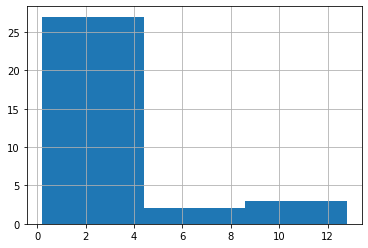

In [46]:
slopes = []
win = []
macd = []
macd_signal = []
bail_outs = []
symbols = []
r_ids = []
scalp = []

for run_id, count in runs.items():
    for symbol in minute_history:
        if symbol not in trade_details[run_id]:
            print(f'1 {symbol}')
            continue
        for trade in trade_details[run_id][symbol]:
            if math.isnan(trade[3]):
                print(f'2 {symbol}')
                continue 
                
            min_time = trade_details[run_id][symbol][0][0]
            max_time = trade_details[run_id][symbol][-1][2]
            
            if min_time is None or max_time is None:
                print(f'3 {symbol}')
                continue
             
            try:
                max_val = minute_history[symbol]['close'][min_time:max_time].max()
            except Exception:
                print(f'4 {symbol}')
                continue
                
            if math.isnan(max_val):
                print(f'5 {symbol}')
                continue
            max_val_index = minute_history[symbol]['close'][min_time:max_time].idxmax()
            
            macds = MACD(
                minute_history[symbol]["close"][:max_val_index]
                .dropna()
                .between_time("9:30", "16:00"),
                13,
                21,
            )
            
            macd_val = macds[0][-1].round(2)
            
            if math.isnan(macd_val):
                print(macds[0][-5])
            macd.append(macd_val)
            macd_signal_val = macds[1][-1].round(2)
            macd_signal.append(macd_signal_val)
            
            bail_out = ((max_val - trade[1]) / trade[1] > 0.003 and macd_val == macd_signal_val)
            bail_outs.append(bail_out)
            #if bail_out == True:
            #     print('bailout!!!')
            
            slope = 100.0 * (max_val - trade[1]) / trade[1]
            slopes.append(slope)
            win.append(trade[3] >= trade[1])
            symbols.append(symbol)
            r_ids.append(run_id)
            #plt.scatter(slope, int(trade[3] >= trade[1]), c=('g' if win else 'r'), s=10)
            
#plt.show()           


d = {
    'symobl':symbols,
    'run': r_ids,
    'win': win,
    'max_val %': slopes,
    'bail_outs': bail_outs,
    'macd': macd,
    'macd_signal': macd_signal,
}
slope_analysis = pd.DataFrame(data=d)
print("all")
display(HTML(slope_analysis.sort_values(by=['win']).to_html()))
print("winners analysis")
display(HTML(slope_analysis.loc[slope_analysis['max_val %'] > 0].sort_values(by=['win']).to_html()))
slope_analysis.loc[slope_analysis['max_val %'] > 0.003]['max_val %'].hist(bins=3)


ARCT analysis for run 77
buy-price 17.0 sell-price 17.07
buy-price 18.03 sell-price 18.34
buy-price 18.24 sell-price 18.46
buy-price 18.75 sell-price 17.8


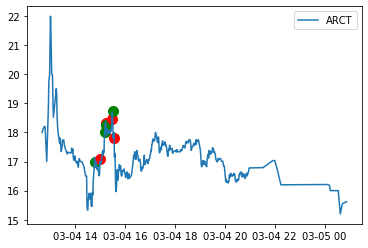

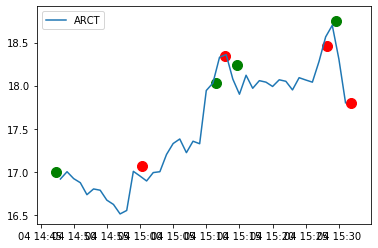

Delta = -0.34999999999999787


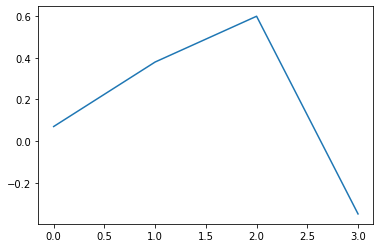

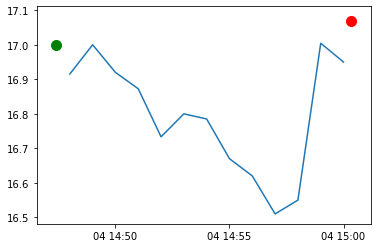

buy time:2020-03-04T14:47:24.41074936Z sell time:2020-03-04T15:00:20.583876907Z
{'rsi': 64.80106582036134, 'macd1': [0.3881778124639226, 0.4288088458948476, 0.4677213781168561, 0.5271802409333386, 0.5621730224455881], 'macd2': [0.19213435088860642, 0.20968679495535625, 0.22789928060820408, 0.251168106023945, 0.27105490924566666], 'sell_macd': [0.23691101943993687, 0.2622884493739619, 0.2864489343956187, 0.3238928326670969, 0.3452271321946494], 'macd_signal': [0.3449748153854018, 0.36174162148729094, 0.38293757281320395, 0.4117861064372309, 0.4418634896389023], 'sell_macd_signal': [0.21328675067540698, 0.22308709041511796, 0.2357594592112181, 0.25338613390239384, 0.27175433356084494]}
{'rsi': 62.91702521479531, 'macd': [0.23189980437229707, 0.20480175200492923, 0.18310454558873346, 0.18743003999703944, 0.19589367148406822], 'scalp': 0, 'bail_out': 1, 'movement': 0.004651435266549484, 'too_close': 0, 'macd_signal': [0.2797840383890716, 0.26478758111224315, 0.2484509740075412, 0.236246787

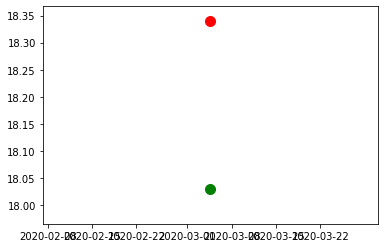

buy time:2020-03-04T15:11:23.495888089Z sell time:2020-03-04T15:12:49.398512668Z
{'rsi': 74.50852684060499, 'macd1': [0.33328007475972043, 0.3333247818977547, 0.32724784553128217, 0.3680565381725778, 0.4043703966445591], 'macd2': [0.37383567272019036, 0.37715042847583646, 0.37913309592079614, 0.39023488936628326, 0.40153608375277017], 'sell_macd': [0.18720420338027566, 0.18744253030710212, 0.1836874275188194, 0.2104797184952396, 0.23418176706783456], 'macd_signal': [0.3421906398375122, 0.3404174682495607, 0.337783543705905, 0.34383814259923956, 0.3559445934083035], 'sell_macd_signal': [0.19264696878590346, 0.19160608109014318, 0.19002235037587842, 0.19411382399975066, 0.20212741261336745]}
{'rsi': 78.61783068716723, 'macd': [0.18744253030710212, 0.1836874275188194, 0.2104797184952396, 0.2331428060288765, 0.2690732274053609], 'scalp': 0, 'bail_out': 0, 'movement': 0.021606648199446014, 'too_close': 0, 'macd_signal': [0.19160608109014318, 0.19002235037587842, 0.19411382399975066, 0.20191

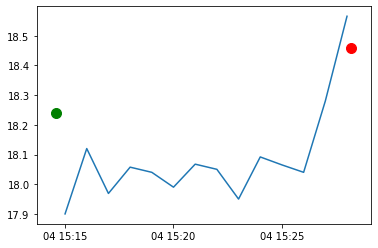

buy time:2020-03-04T15:14:36.131467206Z sell time:2020-03-04T15:28:11.89301653Z
{'rsi': 73.90008584122921, 'macd1': [0.3680565381725778, 0.40277495504912153, 0.4493175898663644, 0.483055351163447, 0.4952082370667057], 'macd2': [0.39023488936628326, 0.40121621170159116, 0.41547577101655975, 0.42841033435109566, 0.4378660676159356], 'sell_macd': [0.2104797184952396, 0.2331428060288765, 0.26335894169107377, 0.2850421780292649, 0.29252207416254095], 'macd_signal': [0.34383814259923956, 0.355625505089216, 0.37436392204464564, 0.3961022078684059, 0.41592341370806585], 'sell_macd_signal': [0.19411382399975066, 0.20191962040557582, 0.21420748466267542, 0.2283744233359933, 0.24120395350130283]}
{'rsi': 69.9325821816324, 'macd': [0.17158242694027237, 0.16177022989493395, 0.15072474869213792, 0.1526279484212303, 0.1635573514773938], 'scalp': 0, 'bail_out': 1, 'movement': 0.0136986301369863, 'too_close': 0, 'macd_signal': [0.20770174310836154, 0.198515440465676, 0.1889573021109684, 0.1816914313730

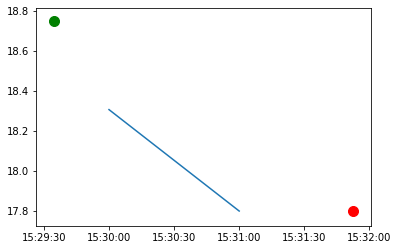

buy time:2020-03-04T15:29:34.563871826Z sell time:2020-03-04T15:31:52.432922257Z
{'rsi': 73.70846312605637, 'macd1': [0.2959030569202312, 0.27834659966139697, 0.28056479867898787, 0.3018723358160891, 0.32985206051534277], 'macd2': [0.43961665746715184, 0.4363059789045991, 0.4364007028997783, 0.4403544642357673, 0.4462401847384321], 'sell_macd': [0.16177022989493395, 0.15072474869213792, 0.1526279484212303, 0.1669547540747942, 0.1855398655701066], 'macd_signal': [0.35271470079852413, 0.3378410805710987, 0.32638582419267653, 0.32148312651735905, 0.3231569133169558], 'sell_macd_signal': [0.198515440465676, 0.1889573021109684, 0.18169143137302077, 0.17874409591337545, 0.18010324984472167]}
{'rsi': 48.45761114673805, 'macd': [0.1526279484212303, 0.1669547540747942, 0.18294246297270078, 0.17258298337402422, 0.13803555792863875], 'scalp': 0, 'bail_out': 0, 'movement': -0.04853333333333334, 'too_close': 1, 'macd_signal': [0.18169143137302077, 0.17874409591337545, 0.1795837693252405, 0.17818361

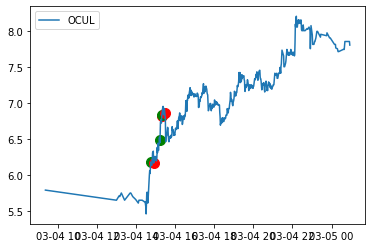

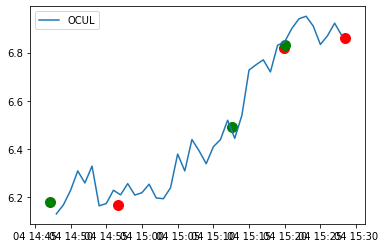

Delta = 0.35000000000000053


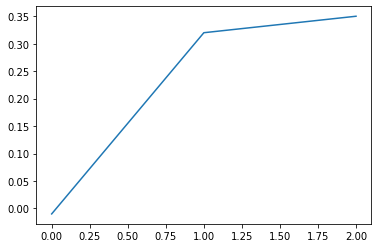

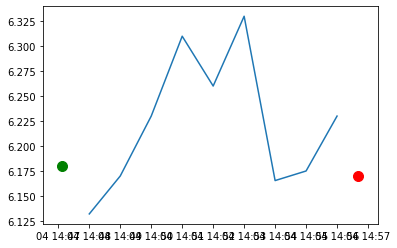

buy time:2020-03-04T14:47:07.581789294Z sell time:2020-03-04T14:56:40.499060482Z
{'rsi': 72.34743855888641, 'macd1': [0.11865264793611274, 0.12796139790003647, 0.13858265330880837, 0.15170662659706124, 0.1618555330012823], 'macd2': [0.050451863235718264, 0.055147894165341604, 0.06033980763691282, 0.06629951722009508, 0.07199647590942782], 'sell_macd': [0.07589200955909536, 0.08147434052617353, 0.08788298361056945, 0.09589123817489664, 0.10192505682015263], 'macd_signal': [0.06921862494096198, 0.08096717953277688, 0.09249027428798318, 0.10433354474979879, 0.1158379424000955], 'sell_macd_signal': [0.04470361322804164, 0.052057758687668015, 0.0592228036722483, 0.06655649057277797, 0.07363020382225291]}
{'rsi': 61.86357125409111, 'macd': [0.11150179651174419, 0.11362140154227518, 0.10524678985772518, 0.09785297828719575, 0.09211945007266387], 'scalp': 0, 'bail_out': 1, 'movement': 0.0032362459546926314, 'too_close': 1, 'macd_signal': [0.09680349794349286, 0.10016707866324932, 0.10118302090

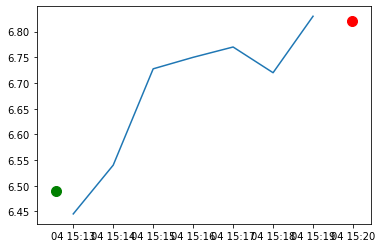

buy time:2020-03-04T15:12:33.693977385Z sell time:2020-03-04T15:19:58.300148154Z
{'rsi': 66.43198718276003, 'macd1': [0.11403176884182731, 0.10929846264388754, 0.1099285109202155, 0.11156255431710793, 0.11556002359596018], 'macd2': [0.11979455606902878, 0.12013995652989795, 0.12138514110980214, 0.12281642025971085, 0.12473649528685993], 'sell_macd': [0.06464770308942036, 0.06158623739944247, 0.06203722209037643, 0.06314140208213814, 0.06577918646426273], 'macd_signal': [0.11643379555266607, 0.11500672897091037, 0.11399108536077139, 0.1135053791520387, 0.113916308040823], 'sell_macd_signal': [0.06642537645566485, 0.06545754864442037, 0.06477348333361158, 0.06444706708331689, 0.06471349095950606]}
{'rsi': 72.86454662145894, 'macd': [0.0798679601245107, 0.08865975452261043, 0.0954032338649915, 0.09681629265301606, 0.10237430868715247], 'scalp': 1, 'bail_out': 0, 'movement': 0.05238828967642525, 'too_close': 0, 'macd_signal': [0.0686931709665579, 0.0726864876777684, 0.07722983691521303, 0.

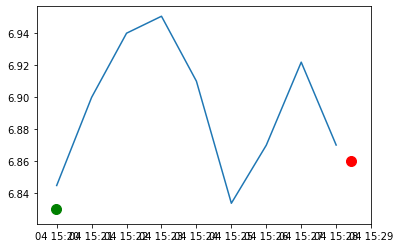

buy time:2020-03-04T15:19:59.482836949Z sell time:2020-03-04T15:28:26.330941443Z
{'rsi': 72.86454662145894, 'macd1': [0.13715342797383379, 0.15075725660464112, 0.16130091428855486, 0.16372684649915836, 0.17253660140491167], 'macd2': [0.13277796159151478, 0.13724072883406802, 0.14144859149291555, 0.1442924529931302, 0.14843741720745296], 'sell_macd': [0.0798679601245107, 0.08865975452261043, 0.0954032338649915, 0.09681629265301606, 0.10237430868715247], 'macd_signal': [0.12001404003081258, 0.12616268334557829, 0.1331903295341736, 0.13929763292717054, 0.14594542662271875], 'sell_macd_signal': [0.0686931709665579, 0.0726864876777684, 0.07722983691521303, 0.08114712806277363, 0.0853925641876494]}
{'rsi': 64.02444098175638, 'macd': [0.11503584826229751, 0.1081182584166811, 0.10320950972637366, 0.10074023139981758, 0.094292219308997], 'scalp': 0, 'bail_out': 1, 'movement': 0.004392386530014678, 'too_close': 1, 'macd_signal': [0.10438779300049313, 0.10513388608373073, 0.10474901081225932, 0.1

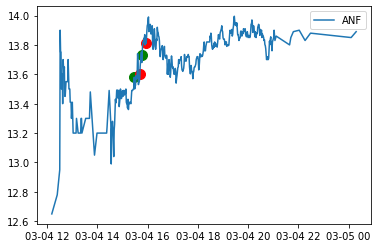

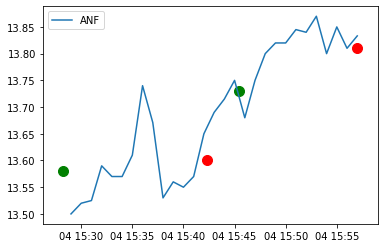

Delta = 0.09999999999999964


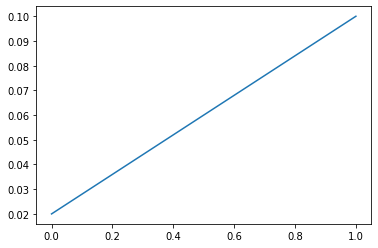

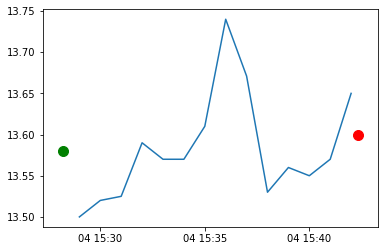

buy time:2020-03-04T15:28:11.560264007Z sell time:2020-03-04T15:42:18.596422617Z
{'rsi': 67.82866034089757, 'macd1': [0.023798753055963573, 0.02600232736083541, 0.0278313120457252, 0.029744832103164143, 0.03648910186778842], 'macd2': [0.07683385623603023, 0.07621836243383306, 0.07561015584103359, 0.07508959446822239, 0.07561011822003927], 'sell_macd': [0.011466456044370688, 0.013086782812607112, 0.014439157140939685, 0.01582491431702948, 0.020335570372202127], 'macd_signal': [0.020833606718674173, 0.02186735084710642, 0.023060143086830177, 0.02439708089009697, 0.02681548508563526], 'sell_macd_signal': [0.008463691125151702, 0.009388309462642784, 0.010398478998302164, 0.011483766062047627, 0.013254126924078527]}
{'rsi': 58.276907552112654, 'macd': [0.031099549843112584, 0.027566267672739286, 0.02393557679098457, 0.021834576405318273, 0.023030750437198932], 'scalp': 0, 'bail_out': 1, 'movement': 0.0036818851251841467, 'too_close': 0, 'macd_signal': [0.02753327707774711, 0.027539875196745

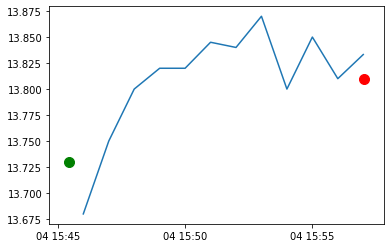

buy time:2020-03-04T15:45:26.325924339Z sell time:2020-03-04T15:57:01.442263444Z
{'rsi': 65.51241297663579, 'macd1': [0.03867369822700084, 0.042097943232812796, 0.04749189082160754, 0.05317100200004532, 0.05900881272959069], 'macd2': [0.07174895245849733, 0.07199503228152615, 0.072746031699225, 0.0737204681379815, 0.07489891530832438], 'sell_macd': [0.021834576405318273, 0.02406971147616055, 0.027576703590112217, 0.0312499870089038, 0.035005143088367774], 'macd_signal': [0.04473664668520238, 0.04420890599472446, 0.04486550296010108, 0.046526602768089925, 0.04902304476039008], 'sell_macd_signal': [0.025822127693538335, 0.025471644450062777, 0.025892656278072666, 0.026964122424238894, 0.02857232655706467]}
{'rsi': 61.22419200813821, 'macd': [0.05270212868609114, 0.04970180022771764, 0.04931580662083235, 0.04629664528273025, 0.04438175793768018], 'scalp': 0, 'bail_out': 1, 'movement': 0.006550218340611343, 'too_close': 1, 'macd_signal': [0.04461048144435425, 0.04562874520102693, 0.0463661

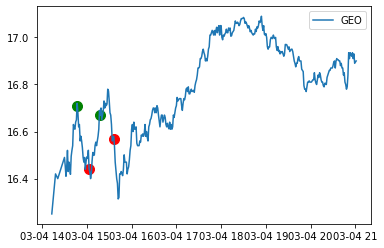

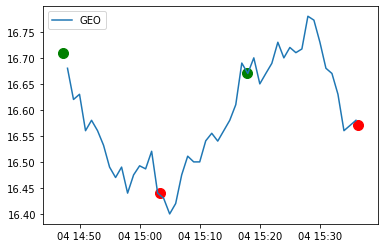

Delta = -0.370000000000001


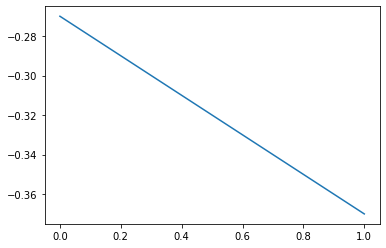

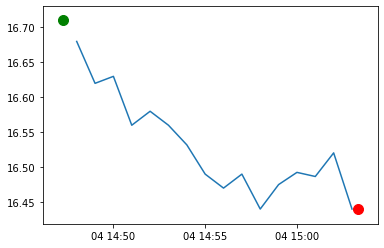

buy time:2020-03-04T14:47:14.200464966Z sell time:2020-03-04T15:03:18.649381425Z
{'rsi': 73.30083274571749, 'macd1': [0.13275512815130952, 0.13375837752660047, 0.13541324951548717, 0.13596435150660113, 0.14043072085569008], 'macd2': [0.05232115756632183, 0.0559945568375646, 0.0597644542769018, 0.06329723164228085, 0.06756581692463115], 'sell_macd': [0.082796195887056, 0.08296881639182985, 0.08358425033851447, 0.08349778003283248, 0.08598237745654913], 'macd_signal': [0.1101473830103758, 0.11486958191362073, 0.11897831543399402, 0.12237552264851545, 0.12598656228995037], 'sell_macd_signal': [0.06984786422450862, 0.07247205465797286, 0.07469449379408119, 0.07645515104183145, 0.07836059632477499]}
{'rsi': 46.94897923098329, 'macd': [0.012742526036699786, 0.01026299217199167, 0.007891108742711594, 0.007696250112847025, 0.004306798581620086], 'scalp': 0, 'bail_out': 0, 'movement': -0.015550239234449642, 'too_close': 0, 'macd_signal': [0.03576742615794041, 0.03066653936075066, 0.026111453237

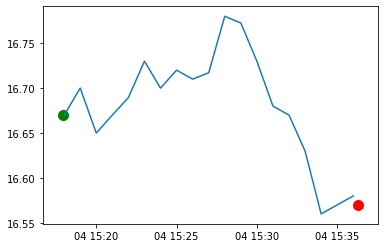

buy time:2020-03-04T15:17:55.401507177Z sell time:2020-03-04T15:36:16.565038946Z
{'rsi': 68.2537289398229, 'macd1': [0.014801275577248418, 0.017949276491165733, 0.021806550409575465, 0.026973285811070724, 0.035500234791602026], 'macd2': [0.05105710525920415, 0.050978117905771114, 0.05114378668950792, 0.05169421800682983, 0.0530775709013227], 'sell_macd': [0.006573723617297134, 0.008792091792184209, 0.011445468398687098, 0.014922833697280424, 0.02055554907673951], 'macd_signal': [0.010532679218247201, 0.012015998672830907, 0.013974109020179818, 0.016573944378357998, 0.020359202461006802], 'sell_macd_signal': [0.002800792945101733, 0.003999052714518228, 0.0054883358513520015, 0.007375235420537686, 0.01001129815177805]}
{'rsi': 43.3290162643965, 'macd': [0.027412260612766914, 0.021491254998409204, 0.01296201354568538, 0.0066669940559549445, 0.002194680245050762], 'scalp': 0, 'bail_out': 0, 'movement': -0.0053989202159570125, 'too_close': 1, 'macd_signal': [0.03252133713449711, 0.030315320

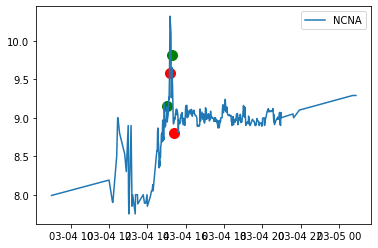

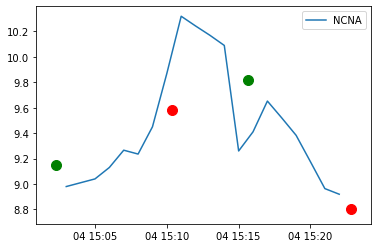

Delta = -0.5899999999999999


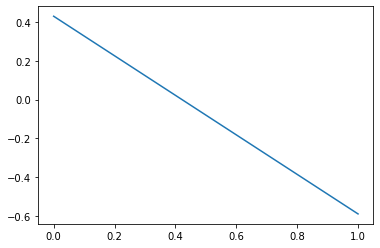

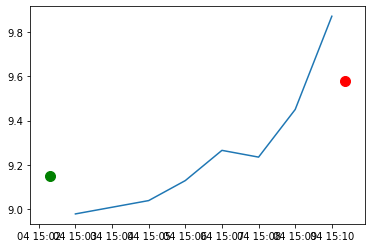

buy time:2020-03-04T15:02:17.776745288Z sell time:2020-03-04T15:10:21.696526251Z
{'rsi': 62.724834378914316, 'macd1': [0.15806062298556434, 0.15350480055490578, 0.1557245430886649, 0.16286850612122628, 0.167407297601196], 'macd2': [0.15593465165200193, 0.1571124361970888, 0.159456151708266, 0.16279684134616623, 0.16576994790011312], 'sell_macd': [0.09026371749865802, 0.08726108336855276, 0.08869719854810221, 0.09333966234322943, 0.0962644437115987], 'macd_signal': [0.16799623318564455, 0.16509794665949679, 0.1632232659453304, 0.16315231398050958, 0.16400331070464685], 'sell_macd_signal': [0.0973107413212363, 0.09530080973069958, 0.0939800874941801, 0.09385200246398998, 0.09433449071351171]}
{'rsi': 71.79702125087249, 'macd': [0.0763705537954138, 0.08395794580744997, 0.08720061561153614, 0.09972736330807663, 0.11676992822345866], 'scalp': 1, 'bail_out': 0, 'movement': 0.05081967213114753, 'too_close': 0, 'macd_signal': [0.08299327757483506, 0.08318621122135804, 0.08398909209939366, 0.08

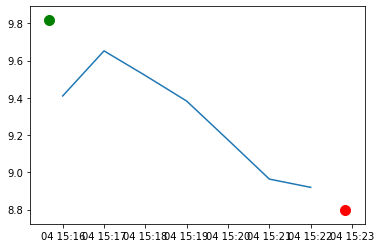

buy time:2020-03-04T15:15:40.820821873Z sell time:2020-03-04T15:22:50.471843049Z
{'rsi': 72.71092404507311, 'macd1': [0.28857141589518065, 0.33396010733984305, 0.35985198687808584, 0.36967095817581885, 0.3774588022617831], 'macd2': [0.2044175824339476, 0.21879781532501497, 0.23050262325026338, 0.2396264747268706, 0.24850111541010378], 'sell_macd': [0.17528694044067272, 0.20433222666593664, 0.2204930701315213, 0.22607693425883824, 0.2302971279391013], 'macd_signal': [0.19058390407517123, 0.2192591447281056, 0.24737771315810164, 0.2718363621616451, 0.29296085018167267], 'sell_macd_signal': [0.11162341893753594, 0.13016518048321607, 0.1482307584128771, 0.16379999358206934, 0.17709942045347574]}
{'rsi': 38.89329596378046, 'macd': [0.12968712002834337, 0.10761349750645266, 0.07818972024905158, 0.043301196149140964, 0.003927005991430477], 'scalp': 0, 'bail_out': 0, 'movement': -0.1384239269730486, 'too_close': 1, 'macd_signal': [0.1555155344359473, 0.14593512705004835, 0.132386045689849, 0.1

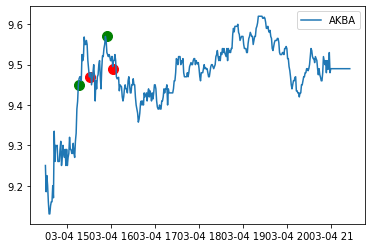

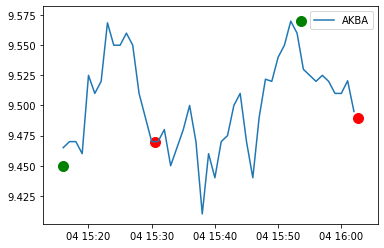

Delta = -0.05999999999999872


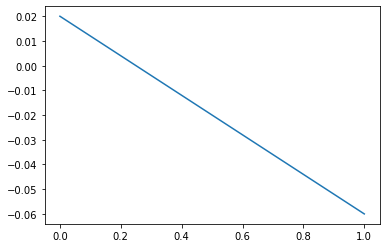

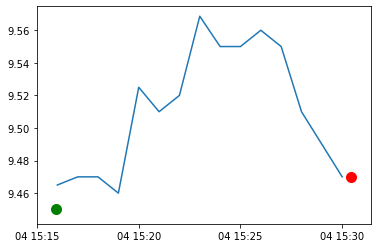

buy time:2020-03-04T15:15:57.459059425Z sell time:2020-03-04T15:30:27.076965322Z
{'rsi': 71.43133487136994, 'macd1': [0.022656976568068643, 0.024494043227299755, 0.03044053085801046, 0.03626025158454382, 0.04368527207872752], 'macd2': [0.04182802133122365, 0.04203595119580683, 0.043119638846196295, 0.044349981400438665, 0.046068341373132426], 'sell_macd': [0.011536494932933294, 0.012824714552193583, 0.016778850430160475, 0.020623906303509187, 0.025487275733345527], 'macd_signal': [0.028409147218947012, 0.027626126420617562, 0.02818900730809614, 0.029803256163385677, 0.03257965934645404], 'sell_macd_signal': [0.015020419081335066, 0.014581278175506768, 0.01502079262643751, 0.016141415361851846, 0.018010587436150582]}
{'rsi': 58.45933618922536, 'macd': [0.04465752154595215, 0.04346384429733696, 0.0398913185932539, 0.03555050221873124, 0.03170635306691416], 'scalp': 0, 'bail_out': 1, 'movement': 0.004232804232804331, 'too_close': 1, 'macd_signal': [0.040174287863380904, 0.0408321991501721

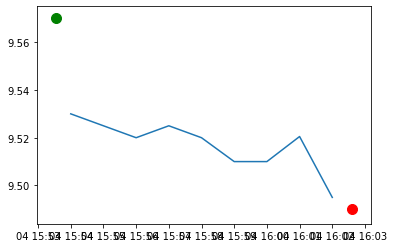

buy time:2020-03-04T15:53:33.10227156Z sell time:2020-03-04T16:02:35.372081245Z
{'rsi': 63.616614695138615, 'macd1': [0.01509069018659659, 0.018167236826545974, 0.021168323375492903, 0.024873809151726434, 0.02749350531086492], 'macd2': [0.04554879959294311, 0.045562062357586086, 0.04566133039917375, 0.045999503306848766, 0.046237063421736835], 'sell_macd': [0.007476315085638063, 0.009575179413019441, 0.01160578564977044, 0.014076312773864785, 0.01581858958778426], 'macd_signal': [0.014374338467951393, 0.015132918139670309, 0.016339999186834826, 0.01804676117981315, 0.0199361100060235], 'sell_macd_signal': [0.006504376489738643, 0.007118537074394802, 0.00801598678946993, 0.009228051986348901, 0.010546159506635972]}
{'rsi': 46.96426385860401, 'macd': [0.010161304303661467, 0.00865385864427104, 0.007366837888326927, 0.006813745898131884, 0.004709859335667588], 'scalp': 0, 'bail_out': 0, 'movement': -0.008359456635318712, 'too_close': 1, 'macd_signal': [0.011372211742113728, 0.010828541122

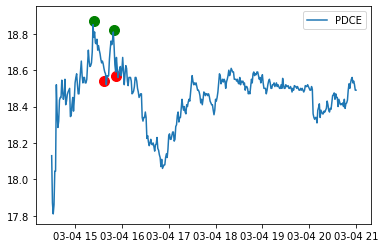

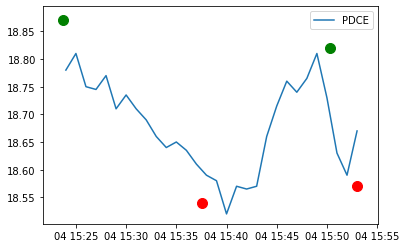

Delta = -0.5800000000000018


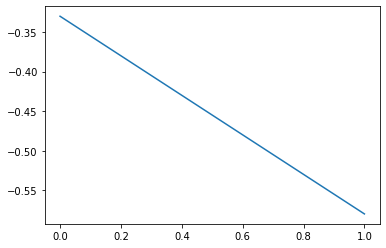

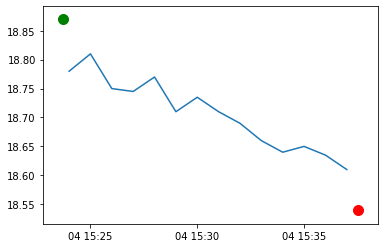

buy time:2020-03-04T15:23:41.771024525Z sell time:2020-03-04T15:37:30.550249951Z
{'rsi': 72.22976168016153, 'macd1': [0.06627256001825899, 0.06389003787649017, 0.06249187907166487, 0.0654706221268988, 0.08221498637670166], 'macd2': [0.11581522830215008, 0.11491012210645479, 0.11413351681068207, 0.114196090640025, 0.1171098043620411], 'sell_macd': [0.03584913095374631, 0.03445363847839644, 0.03369801267321293, 0.03578845993315838, 0.04682272455216463], 'macd_signal': [0.06882248974495987, 0.06783599937126593, 0.06676717531134571, 0.06650786467445632, 0.06964928901490539], 'sell_macd_signal': [0.03676095921329768, 0.03629949506631743, 0.03577919858769653, 0.0357810508567889, 0.037989385595864046]}
{'rsi': 41.82140675824128, 'macd': [0.02550077521254579, 0.0198551870403314, 0.015717648373147597, 0.011510246186080764, 0.0041861633625721595], 'scalp': 0, 'bail_out': 0, 'movement': -0.01746956061408162, 'too_close': 1, 'macd_signal': [0.03667675843615785, 0.03331244415699256, 0.0297934850002

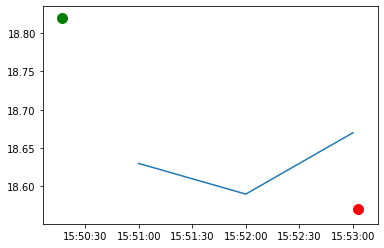

buy time:2020-03-04T15:50:16.779934625Z sell time:2020-03-04T15:53:02.615944471Z
{'rsi': 66.11870205899871, 'macd1': [0.009508712691324916, 0.01612363710250264, 0.023116827030321474, 0.031922125953482094, 0.039254800312612304], 'macd2': [0.07629557666449571, 0.07596053804821068, 0.07593064360268542, 0.07650141141813194, 0.07706411877425978], 'sell_macd': [0.0033016067955848882, 0.0078015455839732795, 0.012505373917992557, 0.018345949581927812, 0.023178268935879487], 'macd_signal': [0.003118154367199243, 0.005719250914259923, 0.009198766137472234, 0.013743438100674205, 0.018845710543061826], 'sell_macd_signal': [-0.00195982850297356, -7.553685584192052e-06, 0.002495031835131158, 0.005665215384490489, 0.00916782609476829]}
{'rsi': 45.667119657618805, 'macd': [0.018345949581927812, 0.01850294426055399, 0.013190174604151395, 0.006801131045861553, 0.0027732902076387234], 'scalp': 0, 'bail_out': 0, 'movement': -0.011158342189160514, 'too_close': 1, 'macd_signal': [0.005665215384490489, 0.008

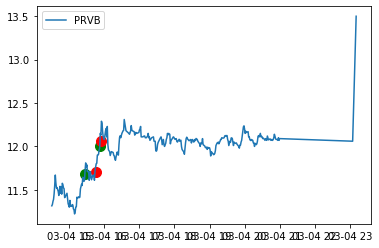

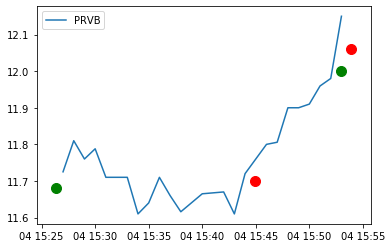

Delta = 0.08000000000000007


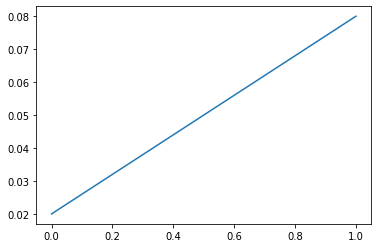

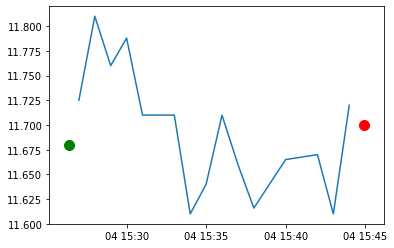

buy time:2020-03-04T15:26:22.607167202Z sell time:2020-03-04T15:44:56.508085246Z
{'rsi': 70.19186749122743, 'macd1': [0.047152917098824076, 0.05865208326138216, 0.0653975600752208, 0.06776740589717178, 0.07540910953662383], 'macd2': [0.030506318493433326, 0.03374684985102405, 0.03635439693395526, 0.038260253891207796, 0.04126718545581198], 'sell_macd': [0.029122298325379603, 0.036525855875634505, 0.04078153895537007, 0.04215503825184719, 0.04694795928479323], 'macd_signal': [0.022792695230860742, 0.029964572836965027, 0.03705117028461618, 0.0431944174071273, 0.04963735583302661], 'sell_macd_signal': [0.012878244765443936, 0.01760776698748205, 0.022242521381059654, 0.02622502475521716, 0.030369611661132372]}
{'rsi': 58.4430172193637, 'macd': [0.035491597593853896, 0.032897633706534535, 0.030708861408538013, 0.025487625054143592, 0.026802406790276123], 'scalp': 0, 'bail_out': 1, 'movement': 0.0034246575342466545, 'too_close': 0, 'macd_signal': [0.04582641384371041, 0.04324065781627524, 0

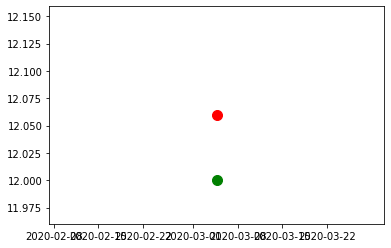

buy time:2020-03-04T15:52:57.492791897Z sell time:2020-03-04T15:53:55.403482142Z
{'rsi': 72.79404973292033, 'macd1': [0.07274720171302107, 0.08069876975006451, 0.0868067074457528, 0.0945515964387198, 0.10277278757065922], 'macd2': [0.06528099570899215, 0.06793676814544902, 0.07043144439643001, 0.07340566441878948, 0.07667238077775451], 'sell_macd': [0.042574444763097574, 0.04769730450427723, 0.05158917827007592, 0.05652324642173667, 0.06173780282015073], 'macd_signal': [0.06298476686812397, 0.06652756744451208, 0.07058339544476022, 0.07537703564355214, 0.08085618602897356], 'sell_macd_signal': [0.03639094018149582, 0.038652213046052104, 0.04123960609085687, 0.04429633415703283, 0.047784627889656414]}
{'rsi': 78.33069410665374, 'macd': [0.04769730450427723, 0.05158917827007592, 0.05652324642173667, 0.06069884178118912, 0.07199542463555275], 'scalp': 0, 'bail_out': 0, 'movement': 0.01250000000000003, 'too_close': 0, 'macd_signal': [0.038652213046052104, 0.04123960609085687, 0.04429633415

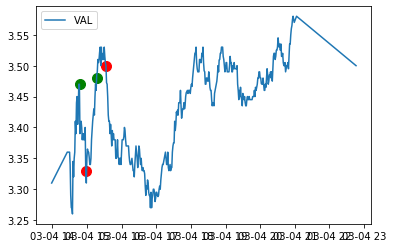

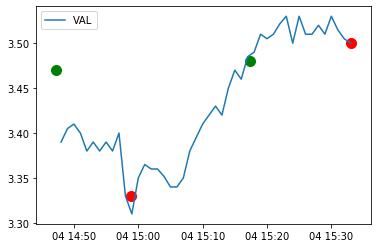

Delta = -0.1200000000000001


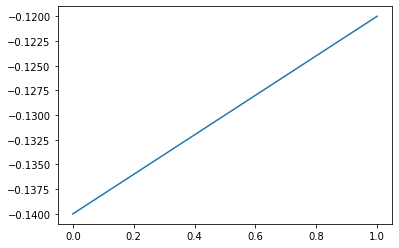

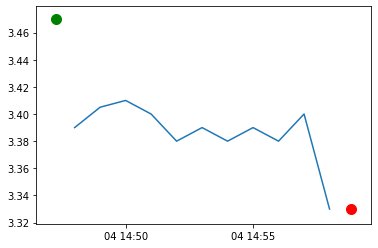

buy time:2020-03-04T14:47:15.509920154Z sell time:2020-03-04T14:58:51.310924122Z
{'rsi': 67.66623577190636, 'macd1': [0.036057243735372335, 0.03622763903168602, 0.03794259102701236, 0.04204470337631916, 0.04477946714427938], 'macd2': [0.017067090947934016, 0.017942155550198624, 0.019118387068635112, 0.020809724603879864, 0.022332526990998414], 'sell_macd': [0.02269076448173557, 0.02268444379378387, 0.023683616714941458, 0.026232535657207734, 0.027878023980308697], 'macd_signal': [0.021237191832789663, 0.024235281272568934, 0.026976743223457618, 0.029990335254029925, 0.032948161632079816], 'sell_macd_signal': [0.01322543381035071, 0.015117235807037343, 0.016830511988618166, 0.01871091672233608, 0.020544338173930605]}
{'rsi': 42.74358710594802, 'macd': [0.011810932091121717, 0.010449199477641002, 0.008732924720673996, 0.008321114199392188, 0.004255792829570115], 'scalp': 0, 'bail_out': 0, 'movement': -0.04034582132564845, 'too_close': 1, 'macd_signal': [0.01737926105468381, 0.01599324873

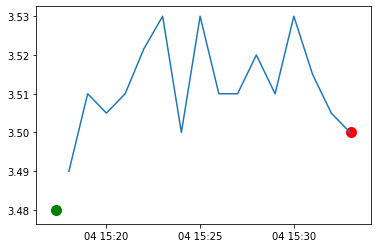

buy time:2020-03-04T15:17:19.56078951Z sell time:2020-03-04T15:33:03.43496443Z
{'rsi': 67.57324484703354, 'macd1': [0.012486734569468805, 0.016167672733005567, 0.020462793257337797, 0.02279700115238592, 0.025961443222268343], 'macd2': [0.01606365112981134, 0.016832758723855257, 0.01783331271785782, 0.018565396480084484, 0.019529116252560375], 'sell_macd': [0.007418949220864057, 0.009818616997122831, 0.012599934524114786, 0.014084078901977382, 0.016096605963922705], 'macd_signal': [0.005346121720982817, 0.007510431923387368, 0.010100904190177454, 0.012640123582619147, 0.015304387510548986], 'sell_macd_signal': [0.002543569165567091, 0.0039985787318782395, 0.005718849890325549, 0.007391895692655916, 0.009132837746909274]}
{'rsi': 57.21971959190274, 'macd': [0.019562861595880054, 0.019345508888926055, 0.018145681988846363, 0.016455613209708453, 0.014924967236227715], 'scalp': 0, 'bail_out': 1, 'movement': 0.007183908045976986, 'too_close': 1, 'macd_signal': [0.02076916138830913, 0.0204844

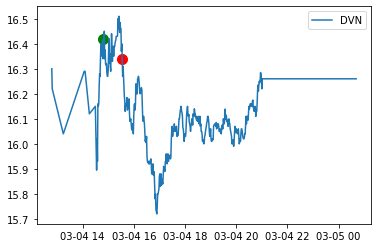

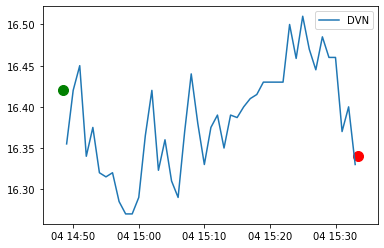

Delta = -0.08000000000000185


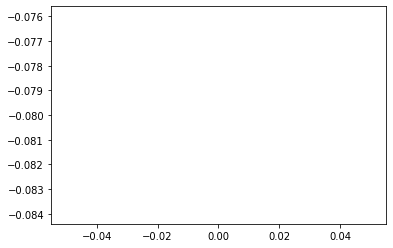

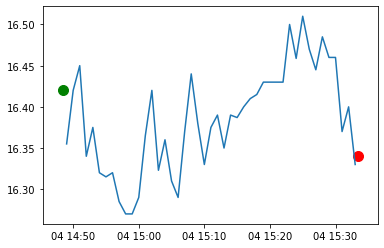

buy time:2020-03-04T14:48:24.889977239Z sell time:2020-03-04T15:33:21.485875772Z
{'rsi': 63.59916087765814, 'macd1': [0.10154848886526224, 0.10824391752998608, 0.11066063323562503, 0.1164781668142787, 0.1205063977740295], 'macd2': [0.04441392039510461, 0.04818202516408121, 0.05125186961540251, 0.0550338386693916, 0.05858528826497533], 'sell_macd': [0.06465780717856617, 0.06862934116573527, 0.0697937917899516, 0.07317136640894972, 0.07537244576909075], 'macd_signal': [0.060718557389613965, 0.0702236294176884, 0.07831103018127572, 0.08594445750787631, 0.09285684556110695], 'sell_macd_signal': [0.038791309177310614, 0.04475891557499555, 0.049765890817986755, 0.054446985936179346, 0.05863207790276163]}
{'rsi': 43.065569085069235, 'macd': [0.021460548861355733, 0.020067297123883776, 0.014045707495672133, 0.010729589506212278, 0.004889373027332056], 'scalp': 0, 'bail_out': 0, 'movement': -0.005175038051750432, 'too_close': 1, 'macd_signal': [0.022143686922233924, 0.021728408962563894, 0.0201

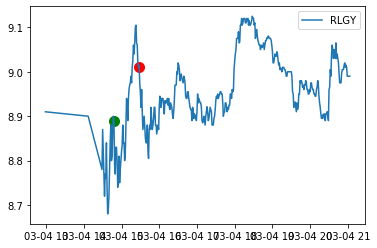

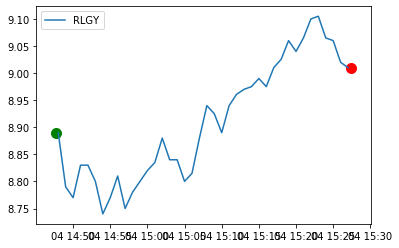

Delta = 0.11999999999999922


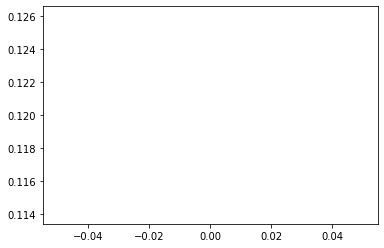

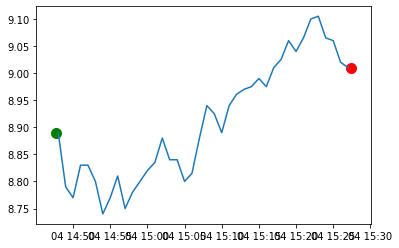

buy time:2020-03-04T14:47:45.439596033Z sell time:2020-03-04T15:27:25.236297106Z
{'rsi': 62.251400254933955, 'macd1': [0.07274200286805943, 0.08113904980658937, 0.0804115048176115, 0.08450916609613301, 0.08914967945000463], 'macd2': [-0.0045962692462246935, -0.0002324091851040322, 0.0025033651601091833, 0.006135913463866771, 0.009947968639032467], 'sell_macd': [0.0478268550517047, 0.05288028982215387, 0.05197543003520266, 0.054231702538420024, 0.05684397068977809], 'macd_signal': [0.047944817538611274, 0.05458366399220689, 0.059749232157287814, 0.06470121894505686, 0.06959091104604641], 'sell_macd_signal': [0.03298390989707397, 0.03696318588208995, 0.03996563471271249, 0.042818848277853996, 0.04562387276023881]}
{'rsi': 56.871601575092136, 'macd': [0.0432930466058874, 0.04171500139769435, 0.039683862256275404, 0.03550785951937385, 0.03179269037997834], 'scalp': 0, 'bail_out': 1, 'movement': 0.013483146067415642, 'too_close': 1, 'macd_signal': [0.037901453938721644, 0.03866416343051619,

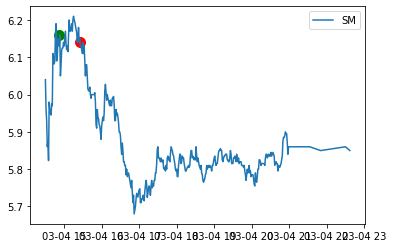

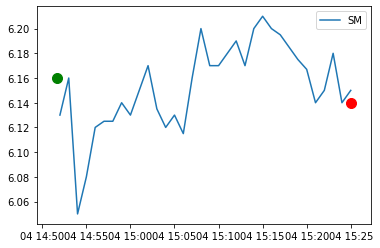

Delta = -0.020000000000000462


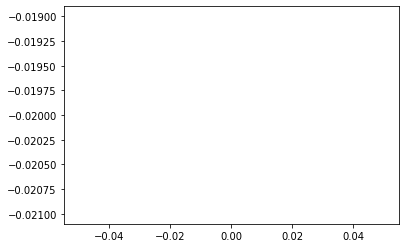

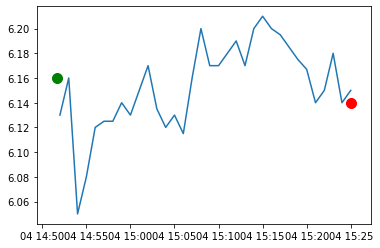

buy time:2020-03-04T14:51:37.126612979Z sell time:2020-03-04T15:25:03.322973564Z
{'rsi': 63.573857408965516, 'macd1': [0.06383981765815072, 0.06246844424420939, 0.061479836079506356, 0.0639932645991319, 0.0660309278028377], 'macd2': [0.018884505732768453, 0.020372480098692414, 0.02186881720209044, 0.02401019921173031, 0.026101874224658594], 'sell_macd': [0.040915930511891574, 0.03976107004420282, 0.038864281757117425, 0.040258157354751134, 0.04134094149115697], 'macd_signal': [0.036395705705590344, 0.041610253413314154, 0.045584169946552594, 0.049265988877068456, 0.0526189766622223], 'sell_macd_signal': [0.023579934399627956, 0.02681616152854293, 0.02922578557425783, 0.03143225993035649, 0.033413996242516585]}
{'rsi': 49.37342650157578, 'macd': [0.010112796569661242, 0.008065265815980993, 0.007923485153165544, 0.005632182232099048, 0.004189190576306068], 'scalp': 0, 'bail_out': 0, 'movement': -0.0019480519480520218, 'too_close': 0, 'macd_signal': [0.015694051674903006, 0.01416829450311

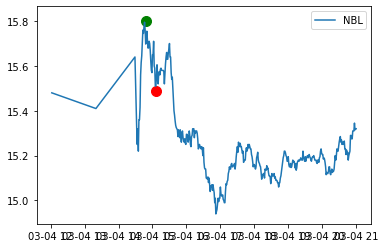

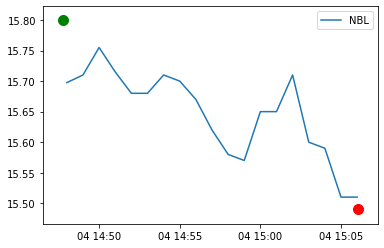

Delta = -0.3100000000000005


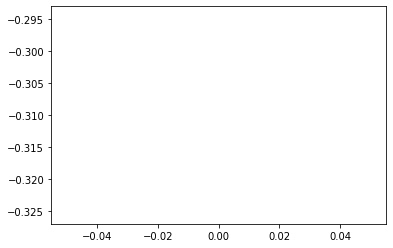

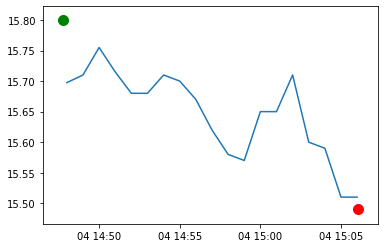

buy time:2020-03-04T14:47:45.447021893Z sell time:2020-03-04T15:06:01.843114674Z
{'rsi': 69.6461578068033, 'macd1': [0.0878859264269245, 0.10391844751267776, 0.11409870252273713, 0.12476301966711212, 0.13249417390082918], 'macd2': [0.0367617643340683, 0.042092339347904684, 0.04668941401781446, 0.051643876696498836, 0.05627947970204339], 'sell_macd': [0.05625346238270623, 0.06635883489749972, 0.07259212731295506, 0.07910388598327245, 0.08367014097334824], 'macd_signal': [0.04447359132869405, 0.05636256256549079, 0.06790979055694006, 0.07928043637897447, 0.08992318388334541], 'sell_macd_signal': [0.028441995157298776, 0.036025363105338964, 0.043338715946862186, 0.05049174995414424, 0.057127428157985036]}
{'rsi': 41.99262971096828, 'macd': [0.02399665200209178, 0.01903367904690434, 0.014399756237059691, 0.006446053317217704, -0.0003548327672984186], 'scalp': 0, 'bail_out': 0, 'movement': -0.019297690604239148, 'too_close': 1, 'macd_signal': [0.035602633139238574, 0.03228884232077173, 0.02

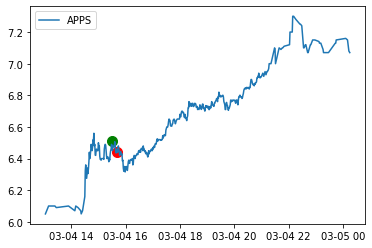

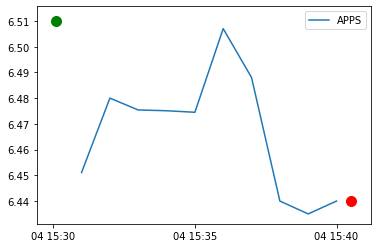

Delta = -0.0699999999999994


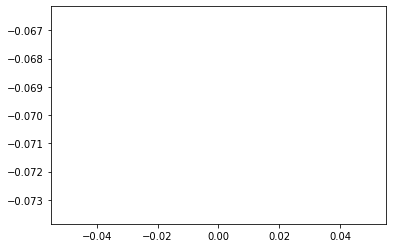

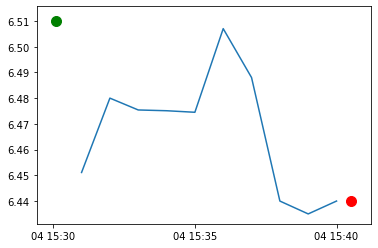

buy time:2020-03-04T15:30:05.823034704Z sell time:2020-03-04T15:40:31.662484669Z
{'rsi': 65.52952929945441, 'macd1': [1.45884877200686e-05, 0.002931461337513319, 0.005981074409716847, 0.010695374401787916, 0.015862471268490275], 'macd2': [0.05596607953313004, 0.055126980289509575, 0.05442675026922572, 0.05417527634769481, 0.05417713856327566], 'sell_macd': [-0.0023586601850418276, -0.0002843241976533406, 0.0018552145483337057, 0.005056735460163608, 0.008524716229639573], 'macd_signal': [0.005822878357870087, 0.0052445949537987336, 0.0053918908449823565, 0.006452587556343469, 0.00833456429877283], 'sell_macd_signal': [0.0006249514887812966, 0.0004430963514943691, 0.0007255199908622364, 0.0015917630847225106, 0.002978353713705923]}
{'rsi': 48.339829525129865, 'macd': [0.011155163499132925, 0.0113440434018095, 0.008850390814260756, 0.006532604501700234, 0.004901438485396703], 'scalp': 0, 'bail_out': 0, 'movement': -0.010752688172042918, 'too_close': 1, 'macd_signal': [0.007664205008239059

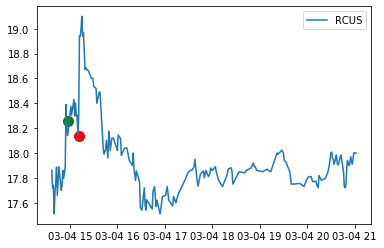

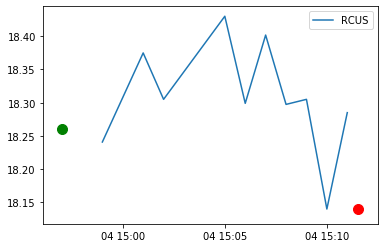

Delta = -0.120000000000001


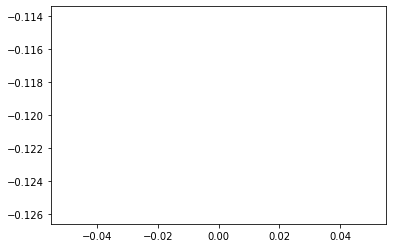

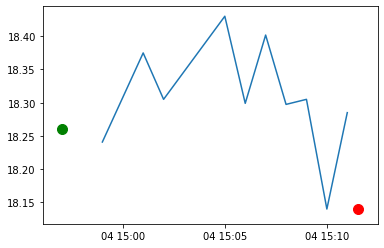

buy time:2020-03-04T14:57:01.567567588Z sell time:2020-03-04T15:11:30.502525975Z
{'rsi': 66.75071870086916, 'macd1': [0.28085238040083027, 0.27913773408036135, 0.3144993332984498, 0.32346355680779837, 0.33158693925178895], 'macd2': [0.1390998141234121, 0.14558055266093817, 0.15930700494570615, 0.1686422063401345, 0.17792078674126444], 'sell_macd': [0.17159677567897447, 0.1696457347698903, 0.1918962777658031, 0.19687207389552697, 0.20130942056939816], 'macd_signal': [0.2636801731200794, 0.2667716853121358, 0.2763172149093986, 0.28574648328907853, 0.2949145744816206], 'sell_macd_signal': [0.1640722522473242, 0.16518694875183743, 0.17052881455463056, 0.17579746642280986, 0.1808998572521275]}
{'rsi': 62.4637755224541, 'macd': [0.19136764514427895, 0.1810277964581033, 0.17101456635903034, 0.1524196524330108, 0.1504960876538668], 'scalp': 0, 'bail_out': 1, 'movement': 0.00876232201533407, 'too_close': 0, 'macd_signal': [0.19221776833989407, 0.1899797739635359, 0.18618673244263478, 0.17943331

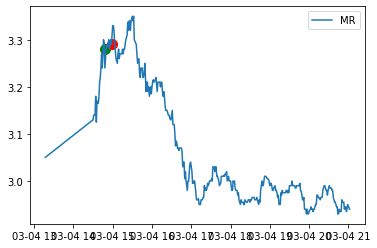

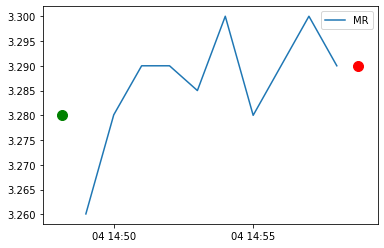

Delta = 0.010000000000000231


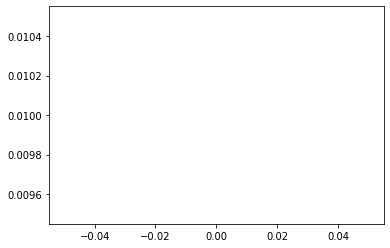

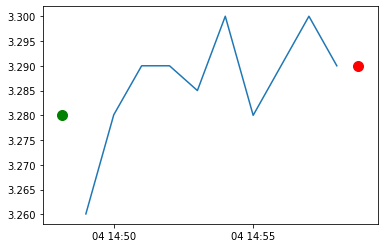

buy time:2020-03-04T14:48:08.992471741Z sell time:2020-03-04T14:58:45.235844318Z
{'rsi': 72.65658007802884, 'macd1': [0.03364752323306597, 0.038723295375520994, 0.0398655864230224, 0.04509255990556005, 0.047908079757627675], 'macd2': [0.010844339622269938, 0.012789488999401133, 0.014078825569085573, 0.016202155494942527, 0.01797623527799619], 'sell_macd': [0.02130600198434429, 0.024484310026728462, 0.025084494085382048, 0.028343280441665897, 0.03001579863563153], 'macd_signal': [0.022148768218850805, 0.025463673650184843, 0.028344056204752353, 0.031693756944913894, 0.03493662150745665], 'sell_macd_signal': [0.01412120464789431, 0.01619382572366114, 0.01797195939600532, 0.020046223605137435, 0.022040138611236253]}
{'rsi': 66.87108743823322, 'macd': [0.02709676566029451, 0.025591676454498558, 0.0246060007557678, 0.024037863837850892, 0.023802460215605947], 'scalp': 0, 'bail_out': 1, 'movement': 0.005956722586919542, 'too_close': 0, 'macd_signal': [0.02643869799448679, 0.02626929368648914

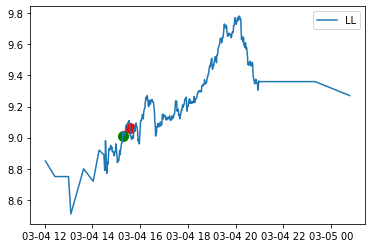

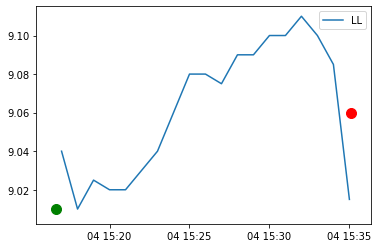

Delta = 0.05000000000000071


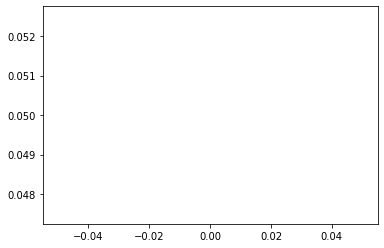

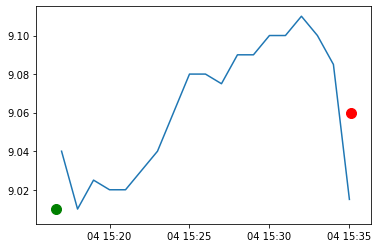

buy time:2020-03-04T15:16:40.633632912Z sell time:2020-03-04T15:35:06.525973362Z
{'rsi': 66.37131901665691, 'macd1': [0.016909452110304812, 0.02065260965659199, 0.023589241812155493, 0.02602005912136285, 0.030818903917790408], 'macd2': [0.039623902443251424, 0.040056910414421054, 0.04043920697579573, 0.04080622319323801, 0.041718370103899005], 'sell_macd': [0.008080422703599766, 0.010638292590256171, 0.012649122468296525, 0.01431146883471257, 0.017498862511988733], 'macd_signal': [0.018426916844600995, 0.018872055406999193, 0.019815492688030453, 0.02105640597469693, 0.023008905563315626], 'sell_macd_signal': [0.008550820455141307, 0.00896831488216428, 0.009704476399390729, 0.010625874886455097, 0.012000472411561824]}
{'rsi': 57.00322631451166, 'macd': [0.028501788420065566, 0.028421224119002275, 0.027469859415329978, 0.02559256406941124, 0.022498664266494828], 'scalp': 0, 'bail_out': 1, 'movement': 0.005549389567147693, 'too_close': 1, 'macd_signal': [0.027294413074848367, 0.0275197752

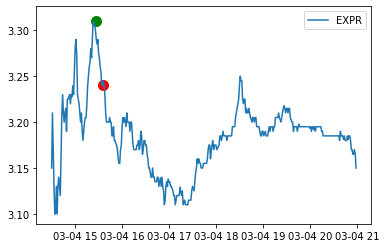

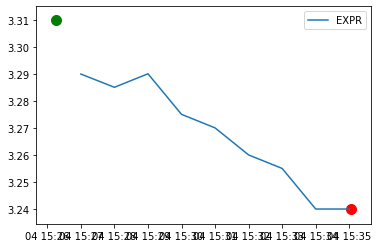

Delta = -0.06999999999999984


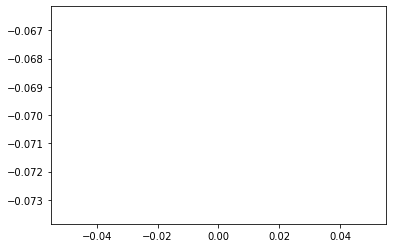

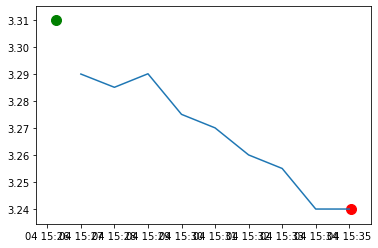

buy time:2020-03-04T15:26:15.704020801Z sell time:2020-03-04T15:35:03.339338619Z
{'rsi': 69.07000848703473, 'macd1': [0.01626588616827851, 0.018739356962081732, 0.02205914910010831, 0.024009879133033873, 0.02566347241657363], 'macd2': [0.012039422720203419, 0.012830544058903381, 0.013857752385218358, 0.014700685351755283, 0.015532666964948039], 'sell_macd': [0.009707773502627859, 0.011304769621701016, 0.013441328031086552, 0.014671875778256016, 0.015699940571137994], 'macd_signal': [0.010476162828250554, 0.012128801655016789, 0.014114871144035094, 0.01609387274183485, 0.018007792676782604], 'sell_macd_signal': [0.005857012485126408, 0.006946563912441329, 0.008245516736170374, 0.009530788544587502, 0.0107646189498976]}
{'rsi': 44.59915017719144, 'macd': [0.010908392861808558, 0.009116175419145556, 0.007341510198640044, 0.005084089115146906, 0.00325903256807214], 'scalp': 0, 'bail_out': 0, 'movement': -0.021148036253776387, 'too_close': 1, 'macd_signal': [0.012070316393397628, 0.01147948

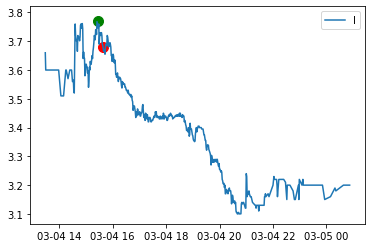

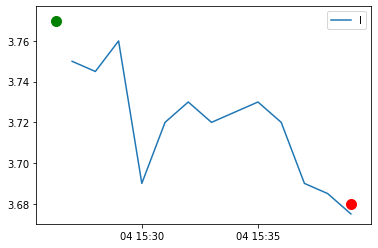

Delta = -0.08999999999999986


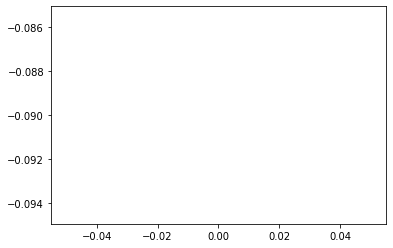

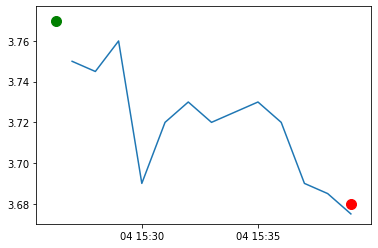

buy time:2020-03-04T15:26:19.009269551Z sell time:2020-03-04T15:39:00.588267805Z
{'rsi': 67.59122028381167, 'macd1': [0.023708412353927955, 0.02652065803939596, 0.027097538185680836, 0.03081449513008483, 0.03351906829017226], 'macd2': [0.021214829873038354, 0.022049061499445965, 0.022515823085357933, 0.02362576115686643, 0.02463794206766723], 'sell_macd': [0.014945502697642166, 0.01671119115662556, 0.017007686174578485, 0.01934511493954716, 0.021008759237710173], 'macd_signal': [0.011390953492615503, 0.014416894401971594, 0.016953023158713443, 0.01972531755298772, 0.022484067700424628], 'sell_macd_signal': [0.006822655477958852, 0.008800362613692193, 0.010441827325869452, 0.012222484848604994, 0.01397973972642603]}
{'rsi': 45.963067825744574, 'macd': [0.011625470327508047, 0.01094955676881737, 0.009761188323489378, 0.007149976699551974, 0.0047626692432434226], 'scalp': 0, 'bail_out': 0, 'movement': -0.022546419098143228, 'too_close': 1, 'macd_signal': [0.01461281799775948, 0.0138801657

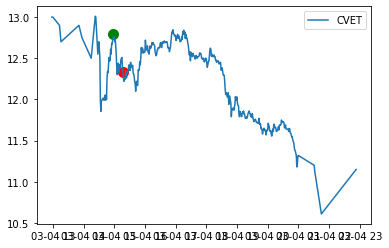

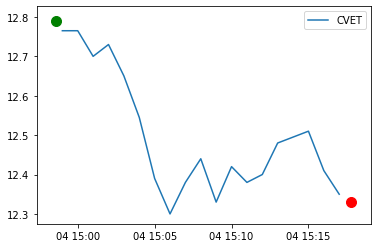

Delta = -0.4599999999999991


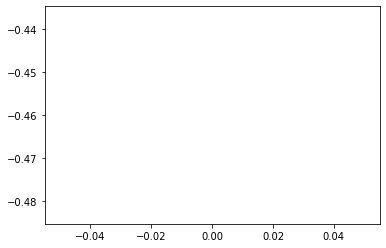

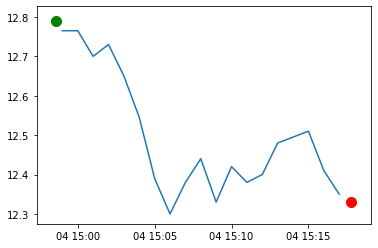

buy time:2020-03-04T14:58:36.519004638Z sell time:2020-03-04T15:17:47.728094891Z
{'rsi': 65.52526928299612, 'macd1': [0.24988408340114, 0.2562338891638465, 0.25774631374529555, 0.259727315183806, 0.2645736574483504], 'macd2': [0.1899397604063875, 0.19575987970155317, 0.20069272855375964, 0.2056586279119017, 0.2111523903714918], 'sell_macd': [0.14729838428469222, 0.15110233590912614, 0.15175083930597033, 0.152716545338496, 0.1555584390607443], 'macd_signal': [0.23702185260547004, 0.24086425991714533, 0.24424067068277538, 0.2473379995829815, 0.2507851311560553], 'sell_macd_signal': [0.1404744163110542, 0.1426000002306686, 0.14443016804572895, 0.14608744350428235, 0.14798164261557473]}
{'rsi': 43.28670299875344, 'macd': [0.012814411007719073, 0.013743967640175825, 0.015069025176634554, 0.010711030722228898, 0.0030202424366905234], 'scalp': 0, 'bail_out': 0, 'movement': -0.036598324790598886, 'too_close': 1, 'macd_signal': [0.040952937447359464, 0.035511143485922735, 0.031422719824065096, 

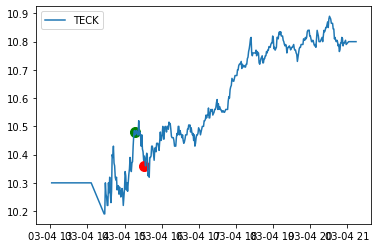

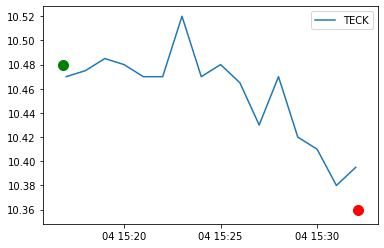

Delta = -0.120000000000001


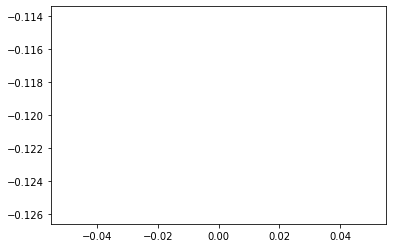

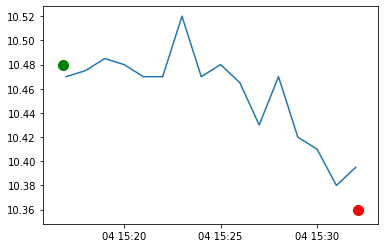

buy time:2020-03-04T15:16:49.582365639Z sell time:2020-03-04T15:32:05.628366811Z
{'rsi': 68.06641253960316, 'macd1': [0.03017267738772489, 0.0312714310402562, 0.03616337272197967, 0.042774855547012436, 0.048265050289733935], 'macd2': [0.03801838029771076, 0.038406693759554855, 0.03958217656669838, 0.04124009629199499, 0.042859413726118234], 'sell_macd': [0.017144335282088363, 0.017883621345283984, 0.021084576441989356, 0.02538292357654015, 0.028922117141430448], 'macd_signal': [0.02596858995759401, 0.02702915817412645, 0.028856001083697094, 0.03163977197636016, 0.03496482763903492], 'sell_macd_signal': [0.014143718240365654, 0.01489169886134932, 0.016130274377477327, 0.01798080421728989, 0.020169066802118003]}
{'rsi': 42.55575728831105, 'macd': [0.02202055314805129, 0.01812781938562935, 0.014339613604708035, 0.00964309463769375, 0.004819273434335969], 'scalp': 0, 'bail_out': 0, 'movement': -0.011450381679389407, 'too_close': 1, 'macd_signal': [0.026996159128653368, 0.025222491180048566

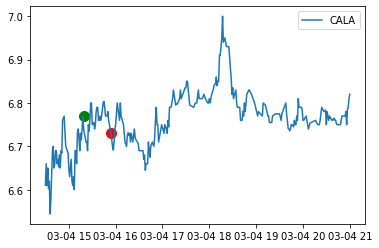

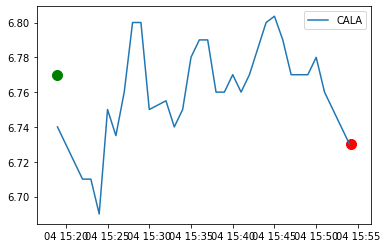

Delta = -0.03999999999999915


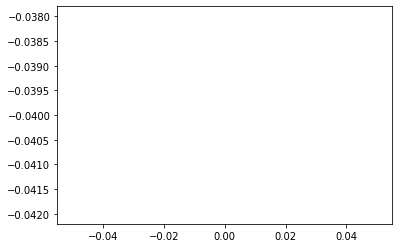

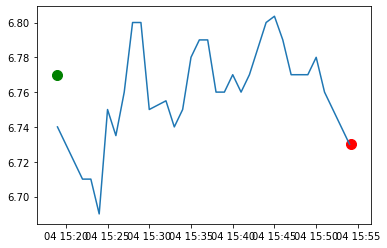

buy time:2020-03-04T15:18:53.708556997Z sell time:2020-03-04T15:54:12.23695291Z
{'rsi': 61.12477208316219, 'macd1': [0.02252867639489331, 0.02434342737752626, 0.0242912416530654, 0.02596783412930659, 0.029378636392695334], 'macd2': [0.03567281049137083, 0.03600271100384411, 0.03600874468444637, 0.036356544972462324, 0.03709819322629482], 'sell_macd': [0.012138234169709605, 0.01338371846008446, 0.013401190394660922, 0.01453946475414103, 0.016796049128357637], 'macd_signal': [0.021083604328357503, 0.021735568938191254, 0.022246703481166082, 0.022990929610794183, 0.024268470967174414], 'sell_macd_signal': [0.01085119728884893, 0.011357701523096037, 0.011766399297409014, 0.012321012388755418, 0.013216019736675862]}
{'rsi': 44.034056335351295, 'macd': [0.00976553525922963, 0.008617787954657175, 0.008131000601032667, 0.006607127330662266, 0.00377544520659967], 'scalp': 0, 'bail_out': 0, 'movement': -0.005908419497784217, 'too_close': 1, 'macd_signal': [0.010918632516701296, 0.010458463604292

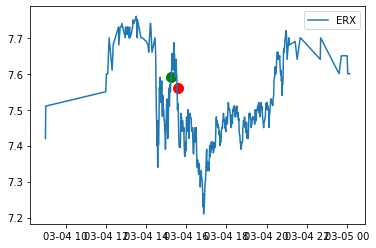

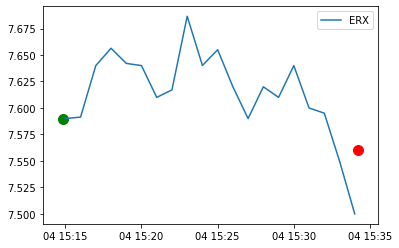

Delta = -0.03000000000000025


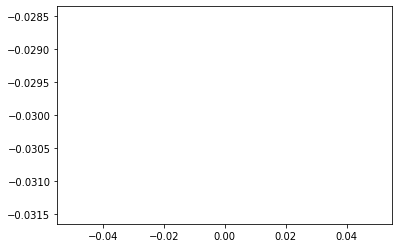

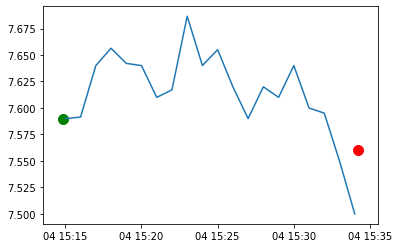

buy time:2020-03-04T15:14:50.509157177Z sell time:2020-03-04T15:34:11.511633971Z
{'rsi': 58.7410474416592, 'macd1': [0.011001371570240615, 0.015011059815282835, 0.019584906049258777, 0.021349772402952105, 0.02591939963273493], 'macd2': [0.020504118237997915, 0.021176576036475048, 0.0220828611584869, 0.022561481958613072, 0.023653469376947456], 'sell_macd': [0.006142144682555362, 0.008782862651533385, 0.011770657657860006, 0.012906982888011953, 0.015858574198675868], 'macd_signal': [0.005722641004167061, 0.007580324766390216, 0.009981241022963928, 0.012254947298961563, 0.014987837765716236], 'sell_macd_signal': [0.0024184371363148703, 0.0036913222393585732, 0.0053071893230588595, 0.006827148036049478, 0.008633433268574756]}
{'rsi': 46.030517124963275, 'macd': [0.016535596337623915, 0.014069575051352423, 0.011710732814630198, 0.0073777293468637595, 0.004425028860983282], 'scalp': 0, 'bail_out': 0, 'movement': -0.0043461082576057375, 'too_close': 1, 'macd_signal': [0.020466818167986556, 0

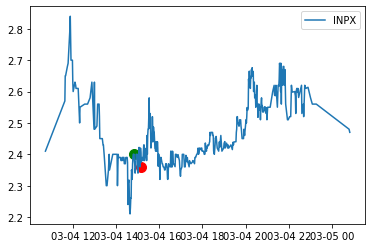

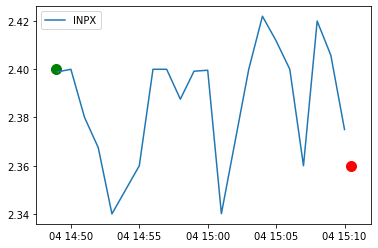

Delta = -0.040000000000000036


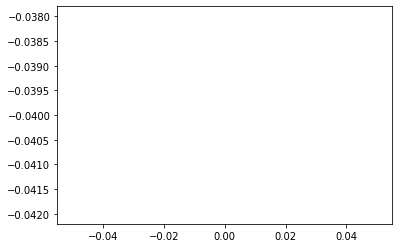

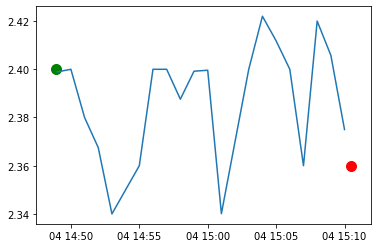

buy time:2020-03-04T14:48:56.420400663Z sell time:2020-03-04T15:10:29.3550805Z
{'rsi': 59.403285937129105, 'macd1': [0.032027438067016245, 0.03557806189305124, 0.040188059911818286, 0.04493733972809677, 0.048943899815173886], 'macd2': [0.01498997612701869, 0.016526657224266827, 0.018361841780792698, 0.02034077512643151, 0.022288860903244334], 'sell_macd': [0.01920637664640701, 0.021438989109144657, 0.024354804156613508, 0.027349532711049118, 0.02984737921176439], 'macd_signal': [0.03275276630692561, 0.03331782542415074, 0.03469187232168425, 0.03674096580296675, 0.039181552605408176], 'sell_macd_signal': [0.020180869946283854, 0.020432493778856014, 0.021216955854407513, 0.022443471225735832, 0.023924252822941545]}
{'rsi': 56.08967299265617, 'macd': [0.017624624227570607, 0.014587260050441309, 0.01514792095072437, 0.014650410990546092, 0.014804943346374166], 'scalp': 0, 'bail_out': 1, 'movement': 0.008291666666666772, 'too_close': 0, 'macd_signal': [0.01992806896082683, 0.018859907178749

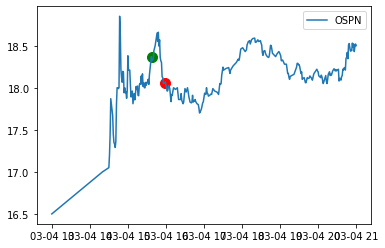

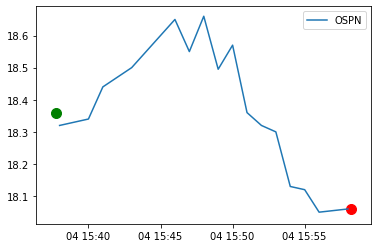

Delta = -0.3000000000000007


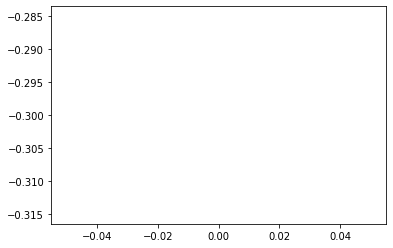

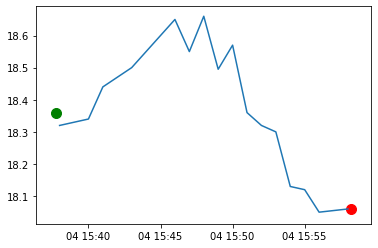

buy time:2020-03-04T15:37:46.696242417Z sell time:2020-03-04T15:58:13.435273463Z
{'rsi': 64.68106723363553, 'macd1': [0.034846592316039704, 0.03691480262959246, 0.033328189027621136, 0.03939191695738842, 0.060765015284612645], 'macd2': [0.15754283296442395, 0.1552150433060575, 0.15186554143595643, 0.15039626275988738, 0.1522265725221139], 'sell_macd': [0.015733338685855358, 0.01740484923760377, 0.015364404872244108, 0.019600884524273, 0.03376436367488722], 'macd_signal': [0.04229661489931983, 0.041220252445374354, 0.03964183976182371, 0.03959185520093665, 0.04382648721767185], 'sell_macd_signal': [0.01888812025335153, 0.018591466050201975, 0.017946053814610403, 0.018277019956542923, 0.02137448870021178]}
{'rsi': 41.78486695160186, 'macd': [0.055483769358779966, 0.03678917995326003, 0.021224705352164364, 0.005184534164918375, -0.006342671100014741], 'scalp': 0, 'bail_out': 0, 'movement': -0.016330974414806788, 'too_close': 1, 'macd_signal': [0.07107311873880347, 0.06421633098169478, 0.0

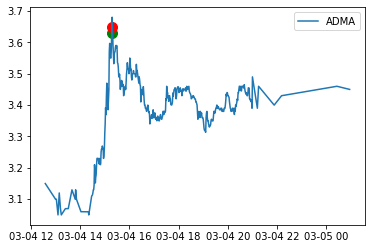

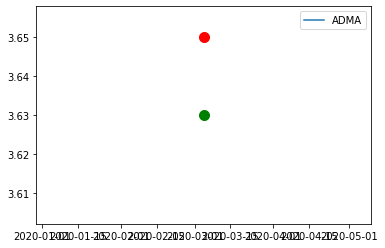

Delta = 0.020000000000000018


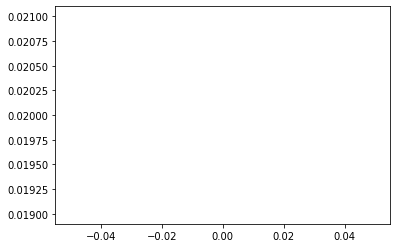

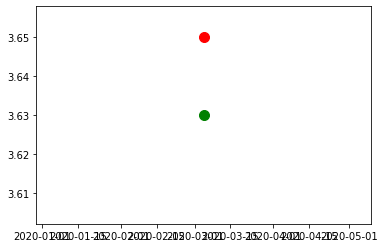

buy time:2020-03-04T15:18:05.557490642Z sell time:2020-03-04T15:18:22.436587196Z
{'rsi': 74.4367528460034, 'macd1': [0.0875200150574229, 0.08686144858589184, 0.08774876603884163, 0.09223029662404336, 0.09402830153696184], 'macd2': [0.061814105417752785, 0.06333646577816676, 0.06511559625645535, 0.06760792606273958, 0.06966007287601794], 'sell_macd': [0.05260634464782976, 0.05201000360253394, 0.05242830923473818, 0.05519025765938146, 0.05619449983885172], 'macd_signal': [0.07538636724445194, 0.07768138351273993, 0.07969486001796026, 0.08220194733917688, 0.08456721817873387], 'sell_macd_signal': [0.045213259922405324, 0.04657260865843105, 0.047743748773692474, 0.04923305055083027, 0.05062534040843456]}
{'rsi': 78.08739991680402, 'macd': [0.05260634464782976, 0.05201000360253394, 0.05242830923473818, 0.05519025765938146, 0.05870359074794251], 'scalp': 0, 'bail_out': 0, 'movement': 0.013299556681444016, 'too_close': 0, 'macd_signal': [0.045213259922405324, 0.04657260865843105, 0.0477437487

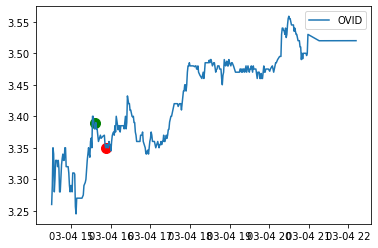

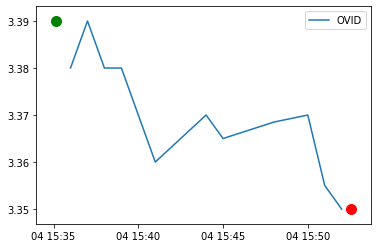

Delta = -0.040000000000000036


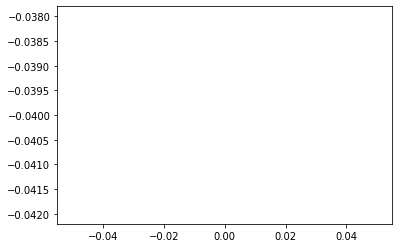

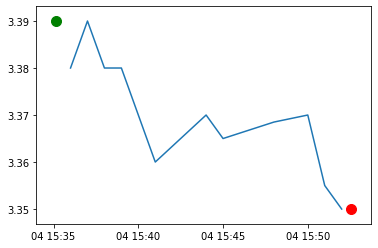

buy time:2020-03-04T15:35:08.519432687Z sell time:2020-03-04T15:52:33.506606452Z
{'rsi': 67.45123821935529, 'macd1': [0.01671432405058937, 0.01701528813077635, 0.021045783770458293, 0.02396374150786773, 0.025179078863298177], 'macd2': [0.012529442835020443, 0.012854869703998517, 0.013933393393203986, 0.01490338517060863, 0.015612036725636713], 'sell_macd': [0.010485604791740322, 0.010634837839734068, 0.013210411151940438, 0.01504578761402442, 0.015761070732349225], 'macd_signal': [0.009102222867467799, 0.01068483592012951, 0.012757025490195266, 0.01499836869372976, 0.01703451072764344], 'sell_macd_signal': [0.005506452529507939, 0.006532129591553164, 0.007867785903630619, 0.009303386245709378, 0.010594923143037348]}
{'rsi': 48.19405078325884, 'macd': [0.008996603472737341, 0.008198772888604378, 0.007548531227090205, 0.006164595760623559, 0.0047464045431087065], 'scalp': 0, 'bail_out': 0, 'movement': -0.011799410029498535, 'too_close': 1, 'macd_signal': [0.01161720068539491, 0.010933515

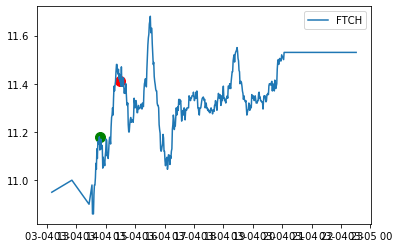

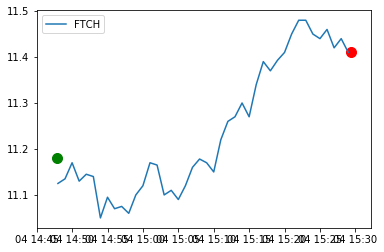

Delta = 0.23000000000000043


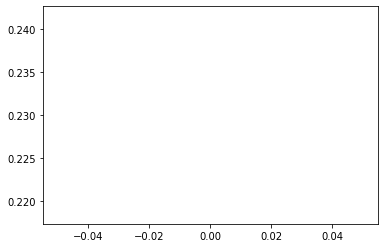

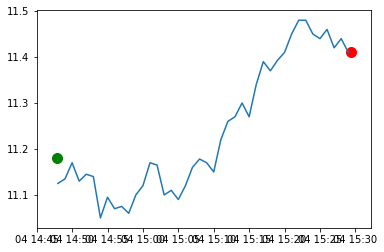

buy time:2020-03-04T14:47:48.408573144Z sell time:2020-03-04T15:29:25.483910017Z
{'rsi': 71.74712275680052, 'macd1': [0.10615750397650814, 0.10897561214799545, 0.11552568992168943, 0.11854326436066209, 0.12194970286001983], 'macd2': [0.03892035749336742, 0.042313978550069464, 0.04648809535825471, 0.050094129102436824, 0.053811485011655336], 'sell_macd': [0.06673907346380403, 0.06819421913762014, 0.07207882331023363, 0.07365021846668185, 0.07547662743967365], 'macd_signal': [0.07515646123768088, 0.0819202914197438, 0.08864137112013293, 0.09462174976823876, 0.10008734038659498], 'sell_macd_signal': [0.04754153362488004, 0.05167207072742806, 0.055753421243989174, 0.05933278068852771, 0.0625615500387569]}
{'rsi': 62.4080638705221, 'macd': [0.055960861235181625, 0.054717353020649284, 0.050959848528536966, 0.048409067774574766, 0.04473821176142678], 'scalp': 0, 'bail_out': 1, 'movement': 0.021440071556350707, 'too_close': 1, 'macd_signal': [0.05177741308400526, 0.05236540107133407, 0.0520842

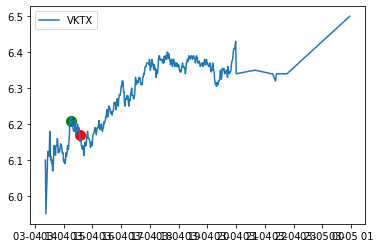

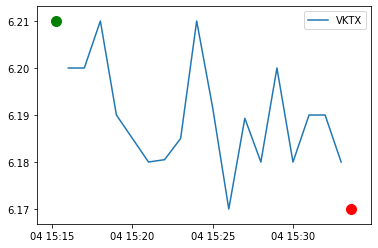

Delta = -0.040000000000000036


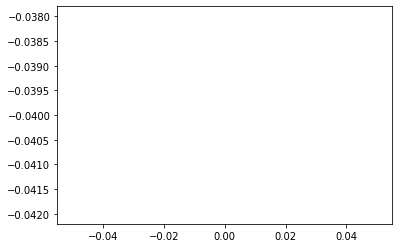

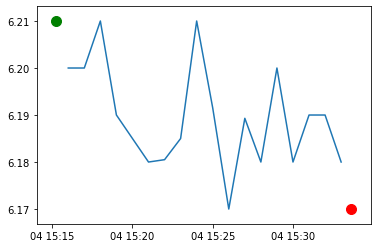

buy time:2020-03-04T15:15:15.219641982Z sell time:2020-03-04T15:33:38.376475529Z
{'rsi': 67.03510233250806, 'macd1': [0.009377461736983506, 0.012174800779382267, 0.01821630799745133, 0.021944368547249127, 0.025245334863504887], 'macd2': [0.01764149215764199, 0.018113130063996508, 0.01931776273183594, 0.02023523123154458, 0.021173317634144873], 'sell_macd': [0.004929163623709876, 0.006789305284985225, 0.010747996121238224, 0.013173625394666821, 0.015303029693511938], 'macd_signal': [0.00804457274539974, 0.008870618352196245, 0.010739756281247261, 0.012980678734447634, 0.015433609960259085], 'sell_macd_signal': [0.0038474408485648344, 0.0044358137358489124, 0.0056982502129267745, 0.0071933252492747835, 0.008815266138122214]}
{'rsi': 51.20420123021718, 'macd': [0.007615247260359226, 0.006596369993676632, 0.00623625303270714, 0.005874652114643553, 0.004997110462715781], 'scalp': 0, 'bail_out': 0, 'movement': -0.006095305488991539, 'too_close': 1, 'macd_signal': [0.009689907334920233, 0.009

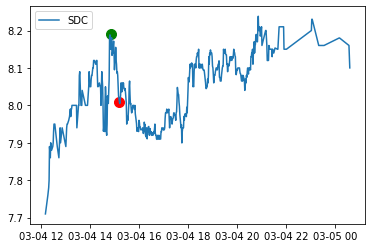

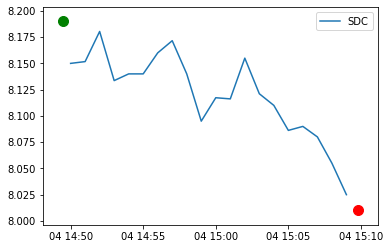

Delta = -0.17999999999999972


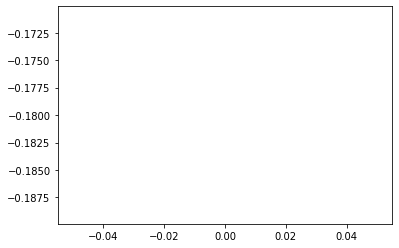

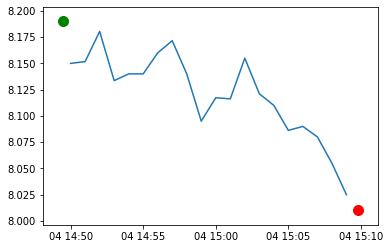

buy time:2020-03-04T14:49:26.755393834Z sell time:2020-03-04T15:09:46.529971765Z
{'rsi': 65.78080117935185, 'macd1': [0.07284491683662253, 0.07621096481514211, 0.08692213101124491, 0.09481011442971621, 0.10004531380966242], 'macd2': [0.04999232576617718, 0.05205212500326706, 0.05565683893550677, 0.05898183669733825, 0.061973796914525536], 'sell_macd': [0.044256216244448865, 0.046248702398210995, 0.053024033136230386, 0.05793177094330826, 0.06109193324826023], 'macd_signal': [0.06942819202219076, 0.07078474658078103, 0.0740122234668738, 0.07817180165944229, 0.08254650408948631], 'sell_macd_signal': [0.04291813673851431, 0.043584249870453645, 0.04547220652360899, 0.04796411940754884, 0.05058968217569112]}
{'rsi': 39.22891447360279, 'macd': [0.019886778824950824, 0.016672365290171243, 0.013431622726834291, 0.009433230823885808, 0.0046366497199787915], 'scalp': 0, 'bail_out': 0, 'movement': -0.020146520146520044, 'too_close': 1, 'macd_signal': [0.03159620742214607, 0.028611438995751103, 0.

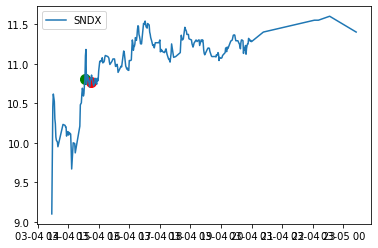

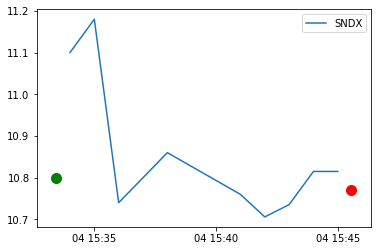

Delta = -0.030000000000001137


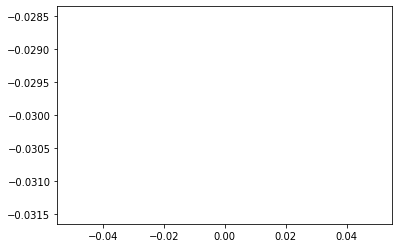

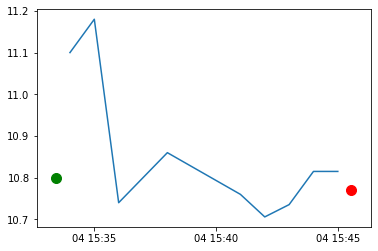

buy time:2020-03-04T15:33:26.068450619Z sell time:2020-03-04T15:45:33.620636053Z
{'rsi': 68.91352901716893, 'macd1': [0.18719460107995722, 0.1923272978142645, 0.1964543132293013, 0.206223863047585, 0.21711996204427386], 'macd2': [0.14747091991258365, 0.15168211820837563, 0.1557745767472749, 0.16104992612393154, 0.16676699098246495], 'sell_macd': [0.11135332404654363, 0.11451868714744684, 0.11699405206831415, 0.12311779029147907, 0.12993216046158906], 'macd_signal': [0.1338386952523553, 0.14553641576473714, 0.15571999525764996, 0.16582076881563695, 0.17608060746136434], 'sell_macd_signal': [0.0761954060952704, 0.08386006230570568, 0.09048686025822737, 0.09701304626487771, 0.10359686910421997]}
{'rsi': 60.16549589239902, 'macd': [0.13895564875459954, 0.12584070476846776, 0.11551944056150276, 0.11011170948384752, 0.10680553319627428], 'scalp': 0, 'bail_out': 1, 'movement': 0.005555555555555437, 'too_close': 0, 'macd_signal': [0.13476646500254896, 0.13298131295573273, 0.12948893847688675, 

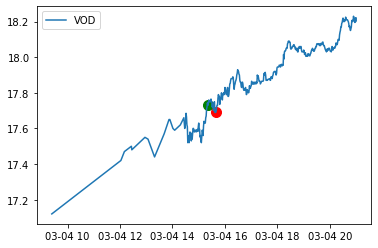

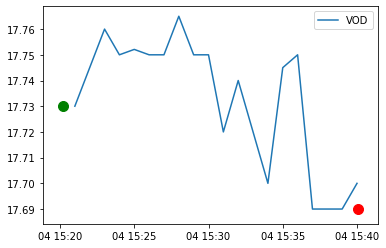

Delta = -0.03999999999999915


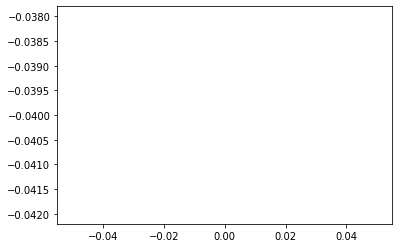

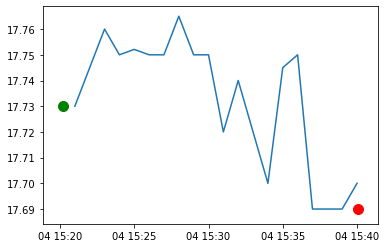

buy time:2020-03-04T15:20:11.351701086Z sell time:2020-03-04T15:40:02.443382079Z
{'rsi': 72.50333333930008, 'macd1': [0.034277912060687754, 0.036372143205884555, 0.04078930842556261, 0.04458293578085559, 0.04855477560872856], 'macd2': [0.08063186651804344, 0.08031104971050596, 0.080527185786881, 0.08075718193585857, 0.08114190501105156], 'sell_macd': [0.017606177000924816, 0.01913425400609725, 0.022154388633428113, 0.02473950147766857, 0.027414401077361816], 'macd_signal': [0.03382801658470682, 0.034336841908942366, 0.035627335212266416, 0.03741845532598425, 0.03964571938253311], 'sell_macd_signal': [0.01641796295515341, 0.016961221165342176, 0.017999854658959362, 0.019347784022701202, 0.020961107433633323]}
{'rsi': 47.570099960882075, 'macd': [0.015501101270650963, 0.011940475281317475, 0.00901089041584413, 0.006611072463321932, 0.004655226364430831], 'scalp': 0, 'bail_out': 0, 'movement': -0.0027566534565277283, 'too_close': 0, 'macd_signal': [0.02057764221954916, 0.01885020883190282

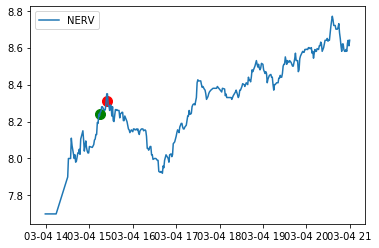

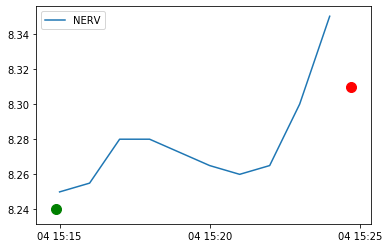

Delta = 0.07000000000000028


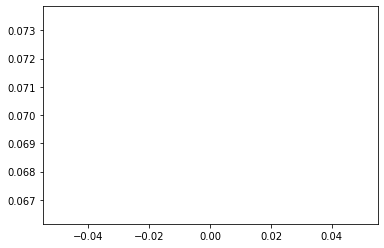

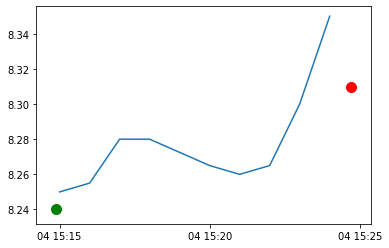

buy time:2020-03-04T15:14:53.046615467Z sell time:2020-03-04T15:24:43.522108432Z
{'rsi': 73.5044245517672, 'macd1': [0.04938417331463363, 0.05441058763237372, 0.05732973745245573, 0.06295209429209336, 0.06663967193805398], 'macd2': [0.05978594298262596, 0.061194275546229804, 0.062312146848374717, 0.06404064476074733, 0.06552849406795502], 'sell_macd': [0.02716782337745549, 0.03050427301067593, 0.03244820424421491, 0.03613895320224181, 0.0385455244266506], 'macd_signal': [0.05379400720152761, 0.053917323287696835, 0.05459980612064862, 0.056270263754937565, 0.058344145391560846], 'sell_macd_signal': [0.029975447347018673, 0.030081212479750125, 0.030554610832643082, 0.031671479306562826, 0.03304628833058038]}
{'rsi': 78.445631848893, 'macd': [0.04325922893555045, 0.04188889631964443, 0.04053683329011193, 0.04077500712047666, 0.04302845416854595], 'scalp': 0, 'bail_out': 0, 'movement': 0.013349514563106726, 'too_close': 0, 'macd_signal': [0.03951644326901321, 0.039990933879139455, 0.040100

In [48]:
for run_id, count in runs.items():
    for symbol in minute_history:
        if symbol not in trade_details[run_id]:
            print(symobl)
            continue
        #if symbol not in high_15m:
        #    print(f'{symbol} not in high_15m, skipping...')
        #    continue
            
        print (f'{symbol} analysis for run {run_id}')
        plt.plot(minute_history[symbol]['close'], label=symbol)

        for trade in trade_details[run_id][symbol]:
 ##           if trade[1] < high_15m[symbol]:
 #               continue
            
#            t = parser.isoparse(trade[0])
#            t = t - timedelta(seconds=t.second, microseconds=t.microsecond)
#            if trade[1] < minute_history[symbol]['open'][pd.Timestamp(t)]:
#                continue
                
                
            print(f'buy-price {trade[1]} sell-price {trade[3]}')

            plt.scatter(parser.isoparse(trade[0]), trade[1], c='g', s=100)
            plt.scatter(parser.isoparse(trade[2]), trade[3], c='r', s=100)
            
        plt.legend()
        plt.show()

        min_time = trade_details[run_id][symbol][0][0]
        max_time = trade_details[run_id][symbol][-1][2]
        delta = 0 
        accumulative_delta = []
        
  #      if min_time not in minute_history[symbol]['close'] or max_time not in minute_history[symbol]['close']:
  #          continue
        plt.plot(minute_history[symbol]['close'][min_time:max_time], label=symbol)
                

        for trade in trade_details[run_id][symbol]:
 #           if trade[1] < high_15m[symbol]:
 #               continue
 #           t = parser.isoparse(trade[0])
 #           t = t - timedelta(seconds=t.second, microseconds=t.microsecond)
 #           if trade[1] < minute_history[symbol]['open'][pd.Timestamp(t)]:
 #               continue 

                
            plt.scatter(parser.isoparse(trade[0]), trade[1], c='g', s=100)
            plt.scatter(parser.isoparse(trade[2]), trade[3], c='r', s=100)
            trade_delta = trade[3] - trade[1]
            delta += trade_delta 
            accumulative_delta.append(delta)
            
        plt.legend()
        plt.show()

        print(f'Delta = {delta}')
        plt.plot(range(len(accumulative_delta)), accumulative_delta)
        plt.show()

        for trade in trade_details[run_id][symbol]:
 #           if trade[1] < high_15m[symbol]:
 #               continue
#            t = parser.isoparse(trade[0])
#            t = t - timedelta(seconds=t.second, microseconds=t.microsecond)
#            if trade[1] < minute_history[symbol]['open'][pd.Timestamp(t)]:
#                continue

                
            plt.plot(minute_history[symbol]['close'][trade[0]:trade[2]])
            plt.scatter(parser.isoparse(trade[0]), trade[1], c='g', s=100)
            plt.scatter(parser.isoparse(trade[2]), trade[3], c='r', s=100)
            plt.show()
            print(f"buy time:{trade[0]} sell time:{trade[2]}")
            print(trade[4])
            print(trade[5])

